<center><img src="https://www.sysmex.co.uk/fileadmin/_processed_/a/9/csm_LifeScience_StageImage_BreastCancer_1500x600-01_2498abd1e0.jpg" width="720"></center>



<center><font size=6>Breast Cancer Survival Analysis</font></center>


## Problem Statement

Cancer is the second leading cause of death in the United States, with breast cancer being the most commonly diagnosed cancer [1]. In 2021, the incidence rate of new breast cancer cases was 133.8 per 100,000 people [2]. This dataset provides real-world data on breast cancer patients, specifically those diagnosed with infiltrating duct and lobular carcinoma between 2006 and 2010. The data comes from the November 2017 update of the SEER Program (Surveillance, Epidemiology, and End Results) of the National Cancer Institute (NCI) and includes detailed clinical and demographic information for 4,024 female patients.

By analyzing this dataset, we aim to gain insights into the factors influencing breast cancer prognosis, including tumor characteristics, treatment outcomes, and survival rates using various machine learning and deep learning models. Such analysis can help inform predictive modeling, guide treatment decisions, and improve early detection strategies.


References:
1. Holland, K. (2018, November). What Are the 12 Leading Causes of Death in the United States? Healthline; Healthline Media.

  https://www.healthline.com/health/leading-causes-of-death#cancer
‌
2. CDC. (2021, June). USCS data visualizations. Gis.cdc.gov.

  https://gis.cdc.gov/Cancer/USCS/#/AtAGlance/

## Variable Description

1. **AGE**: Age of the patient at the time of breast cancer diagnosis.

2. **RACE**: Race recode (White, Black, Other), independent of Hispanic ethnicity.

3. **MARITAL STATUS**: Patient’s marital status at the time of diagnosis.

4. **T STAGE**: Tumor stage from AJCC 6th edition, indicating size/extent of the primary tumor (T0–T4).

5. **N STAGE**: Lymph node stage from AJCC 6th edition, indicating spread to regional lymph nodes (N0–N3).

6. **6TH STAGE**: Overall AJCC 6th edition stage grouping (Stage I–IV), combining T, N, and M categories.

7. **GRADE**: Histologic grade or differentiation of the tumor (1 = well differentiated, 4 = undifferentiated).

8. **A STAGE**: SEER historic stage A, a simplified clinical stage: in situ, localized, regional, distant, or unknown.

9. **TUMOR SIZE**: Size of the primary tumor in millimeters.

10. **ESTROGEN STATUS**: Hormone receptor status: Positive or Negative for estrogen receptor (ER).

11. **PROGESTERONE STATUS**: Hormone receptor status: Positive or Negative for progesterone receptor (PR).

12. **REGIONAL NODES EXAMINED**: Total number of regional lymph nodes that were surgically removed and examined by the pathologist.

13. **REGIONAL NODES POSITIVE**: Number of examined nodes that were found to contain cancer (metastases).

14. **SURVIVAL MONTHS**: Number of months the patient survived after diagnosis.

15. **STATUS**: Vital status of the patient at last follow-up (Alive or Dead).

Data Source: https://ieee-dataport.org/open-access/seer-breast-cancer-data

In [1]:
# Install libraries temporarily in the Colab environment (reset after session ends)
%%capture --no-stderr
%pip install keras keras_tuner

In [2]:
# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Statistical Test libraries
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

# Model selection and evaluation tools
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    RandomizedSearchCV
)

# Metrics to evaluate model performance
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    make_scorer,
    precision_recall_curve,
    average_precision_score
)

# Preprocessing tools for encoding and scaling
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

# Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Ensemble learning models
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    AdaBoostClassifier,
    HistGradientBoostingClassifier,
    ExtraTreesClassifier,
    StackingClassifier
)

# XGBoost classifier
from xgboost import XGBClassifier

# Model interpretability technique
import shap

# Neural network model
from sklearn.neural_network import MLPClassifier

# Necessary Keras components for a neural network model
from keras.models import Sequential
from keras.layers import Dense

# Keras Tuner for hyperparameter tuning of neural networks
import keras_tuner as kt

# DL Model Layers, Optimizer, and Training Callbacks
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Dataset Overview

In [5]:
# Load the dataset
data = pd.read_csv('/content/SEER Breast Cancer Dataset.csv')

In [7]:
# Copy the original dataset
df = data.copy()

In [8]:
# Check the shape of the data
df.shape

(4024, 16)

* This dataset has 4024 rows and 16 columns.

In [9]:
# Check 5 random samples from the data
df.sample(n = 5, random_state = 1)

,Age,Race,Marital Status,Unnamed: 3,T Stage,N Stage,6th Stage,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
486,57,Black,Separated,NaN,T2,N3,IIIC,Poorly differentiated; Grade III,Regional,40,Negative,Negative,36,35,48,Dead
2748,63,White,Married (including common law),NaN,T2,N1,IIB,Moderately differentiated; Grade II,Regional,23,Positive,Positive,19,1,85,Alive
2290,48,White,Married (including common law),NaN,T3,N1,IIIA,Well differentiated; Grade I,Regional,80,Positive,Positive,22,3,78,Alive
957,61,White,Widowed,NaN,T3,N1,IIIA,Moderately differentiated; Grade II,Regional,90,Positive,Positive,13,1,56,Alive
3252,48,White,Divorced,NaN,T4,N1,IIIB,Poorly differentiated; Grade III,Regional,19,Positive,Positive,6,1,94,Alive


* The data is consisted of both numeric and categorical features.
* Status (Alive/Dead) is our target variable for this task.

In [10]:
# Check the information on the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     4024 non-null   int64  
 1   Race                    4024 non-null   object 
 2   Marital Status          4024 non-null   object 
 3   Unnamed: 3              0 non-null      float64
 4   T Stage                 4024 non-null   object 
 5   N Stage                 4024 non-null   object 
 6   6th Stage               4024 non-null   object 
 7   Grade                   4024 non-null   object 
 8   A Stage                 4024 non-null   object 
 9   Tumor Size              4024 non-null   int64  
 10  Estrogen Status         4024 non-null   object 
 11  Progesterone Status     4024 non-null   object 
 12  Regional Node Examined  4024 non-null   int64  
 13  Reginol Node Positive   4024 non-null   int64  
 14  Survival Months         4024 non-null   

* The Unnamed: 3 column is a column with null values only and must be dropped.
* Except for that, there seems to be no null values.
* However, it is a good practice to check for the null values to be sure.

In [11]:
# Check the null values
df.isnull().sum()

,0
Age,0
Race,0
Marital Status,0
Unnamed: 3,4024
T Stage,0
N Stage,0
6th Stage,0
Grade,0
A Stage,0
Tumor Size,0


* As confirmed from .info() function, Unnamed: 3 is the only column with null values.

In [12]:
# Fix the column space if needed
df.columns = df.columns.str.strip()

In [13]:
# Drop the Unnmaed: 3 column
df.drop(columns = 'Unnamed: 3', inplace = True)
df.columns

Index(['Age', 'Race', 'Marital Status', 'T Stage', 'N Stage', '6th Stage',
       'Grade', 'A Stage', 'Tumor Size', 'Estrogen Status',
       'Progesterone Status', 'Regional Node Examined',
       'Reginol Node Positive', 'Survival Months', 'Status'],
      dtype='object')

In [14]:
# Check for sure if there is no null values
df.isnull().any()

,0
Age,False
Race,False
Marital Status,False
T Stage,False
N Stage,False
6th Stage,False
Grade,False
A Stage,False
Tumor Size,False
Estrogen Status,False


* Now, as Unnmaed: 3 is dropped, there are no null values in the data.

In [15]:
# Check the duplicated samples
df.duplicated().any()

np.True_

* No duplication in the data.

In [16]:
# Converting object data type into category
obj_cols = df.select_dtypes(include = 'object').columns.to_list()

for col in obj_cols:
  df[col] = df[col].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Age                     4024 non-null   int64   
 1   Race                    4024 non-null   category
 2   Marital Status          4024 non-null   category
 3   T Stage                 4024 non-null   category
 4   N Stage                 4024 non-null   category
 5   6th Stage               4024 non-null   category
 6   Grade                   4024 non-null   category
 7   A Stage                 4024 non-null   category
 8   Tumor Size              4024 non-null   int64   
 9   Estrogen Status         4024 non-null   category
 10  Progesterone Status     4024 non-null   category
 11  Regional Node Examined  4024 non-null   int64   
 12  Reginol Node Positive   4024 non-null   int64   
 13  Survival Months         4024 non-null   int64   
 14  Status                  

* Converting the data type into category saves memory usage from 503.1+ KB to 198.2 KB.

## Data Description

### Numeric Columns

In [17]:
# Description of the data (numeric columns)
df.describe()

,Age,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months
count,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000
mean,53.972167,30.473658,14.357107,4.158052,71.297962
std,8.963134,21.119696,8.099675,5.109331,22.921430
min,30.000000,1.000000,1.000000,1.000000,1.000000
25%,47.000000,16.000000,9.000000,1.000000,56.000000
50%,54.000000,25.000000,14.000000,2.000000,73.000000
75%,61.000000,38.000000,19.000000,5.000000,90.000000
max,69.000000,140.000000,61.000000,46.000000,107.000000


### Observations:

**Age**:

* The mean age of patients is approximately 54 years, with a minimum age of 30 and a maximum of 69.
* Most patients are over the age of 47. The median age is 54, indicating a relatively balanced distribution around the mean.

**Tumor Size**:

* The average tumor size is around 30 millimeters.
* The 75th percentile shows a tumor size of 38 millimeters, while the maximum size is 140 millimeters. This indicates that most tumors are relatively smaller, but a notable proportion of patients (likely who are Dead) have tumors significantly larger than average.

**Regional Nodes Examined**:

* The mean number of regional nodes examined is about 14.
* The 25th percentile shows 9 nodes examined, while the 75th percentile shows 19 nodes. The maximum is 61, indicating that, for some patients, a much larger number of lymph nodes were examined.

**Regional Nodes Positive**:

* The average number of regional nodes positive is 4.16.
* The median value is 2, while the 75th percentile shows 5. The maximum is 46, which indicates that for some patients, cancer has spread to a significant number of lymph nodes (potentially more advanced stage of cancer).

**Survival Months**:

* The average survival time for patients is 71 months.
* The 25th percentile survival time is 56 months, while the 75th percentile is 90 months, showing a clear difference in the survival period for a large portion of patients. The maximum survival time of 107 months suggests that some patients have a longer survival time.

### Categorical Columns

In [19]:
# Check the values in the categorical features
for col in df.columns:
  if df[col].dtype == 'category':
    print(df[col].value_counts(1))
    print('-' * 50)

Race
White                                                        0.848161
Other (American Indian/AK Native, Asian/Pacific Islander)    0.079523
Black                                                        0.072316
Name: proportion, dtype: float64
--------------------------------------------------
Marital Status
Married (including common law)    0.656809
Single (never married)            0.152833
Divorced                          0.120775
Widowed                           0.058400
Separated                         0.011183
Name: proportion, dtype: float64
--------------------------------------------------
T Stage
T2    0.443837
T1    0.398360
T3    0.132455
T4    0.025348
Name: proportion, dtype: float64
--------------------------------------------------
N Stage
N1    0.678926
N2    0.203777
N3    0.117296
Name: proportion, dtype: float64
--------------------------------------------------
6th Stage
IIA     0.324304
IIB     0.280815
IIIA    0.260934
IIIC    0.117296
IIIB    0.016650
Nam

### Observations:

* **Race**: The dataset has a predominantly White patient population.
* **Marital Status**: The majority are married, indicating potential stress might be a risk factor for breast cancer.
* **Tumor and Cancer Staging**: Most patients have early to moderate-stage cancer, with fewer in advanced stages.
* **Hormone Receptor Status**: A significant proportion of cancers are estrogen and progesterone receptor-positive.

In [18]:
# Change the wrong spelling of the column
df.rename(columns = {'Reginol Node Positive': 'Regional Node Positive'}, inplace = True)

## EDA (Exploratory Data Analysis)

* Let's shorten some values with long names for better visualization.

In [20]:
# Rename categories in 'Race' column
df['Race'] = df['Race'].cat.rename_categories({'Other (American Indian/AK Native, Asian/Pacific Islander)': 'Other'})

# Rename categories in 'Marital Status' column
df['Marital Status'] = df['Marital Status'].cat.rename_categories({'Married (including common law)': 'Married',
                                                                 'Single (never married)': 'Single'})

# Rename categories in 'Grade' column
df['Grade'] = df['Grade'].cat.rename_categories({'Well differentiated; Grade I': 'Grade I',
                                                 'Moderately differentiated; Grade II': 'Grade II',
                                                 'Poorly differentiated; Grade III': 'Grade III',
                                                 'Undifferentiated; anaplastic; Grade IV': 'Grade IV'})

### Univariate Analysis

### a) Numeric Features

In [21]:
# Function to plot histogram and boxplot for numeric columns
def hist_boxplot(var, figsize=(10, 8)):
    """
    Visualizes a histogram and boxplot for a given numeric variable.

    Parameters:
    - var: Column name of the numeric variable.
    - figsize: Size of the combined plot set to default = (10, 8).

    Output:
    - Combined boxplot and histogram.
    """

    # Create subplot with 2 rows: boxplot (25 percent) + histogram (75 percent)
    fig, (ax_box, ax_hist) = plt.subplots(
        nrows = 2, sharex = True, figsize = figsize,
        gridspec_kw = {'height_ratios': (0.25, 0.75)}
    )

    # Draw the boxplot (top)
    sns.boxplot(data = df, x = var, showmeans = True, ax = ax_box)

    # Draw the histogram with KDE (bottom) andvertical lines for mean and median
    sns.histplot(data = df, x = var, kde = True, ax = ax_hist)
    ax_hist.axvline(df[var].median(), color = 'black', linestyle = '--', label = 'Median')
    ax_hist.axvline(df[var].mean(), color = 'red', linestyle = '--', label = 'Mean')

    # Improve layout and display
    plt.tight_layout()
    ax_hist.legend()
    plt.show()

**Age**

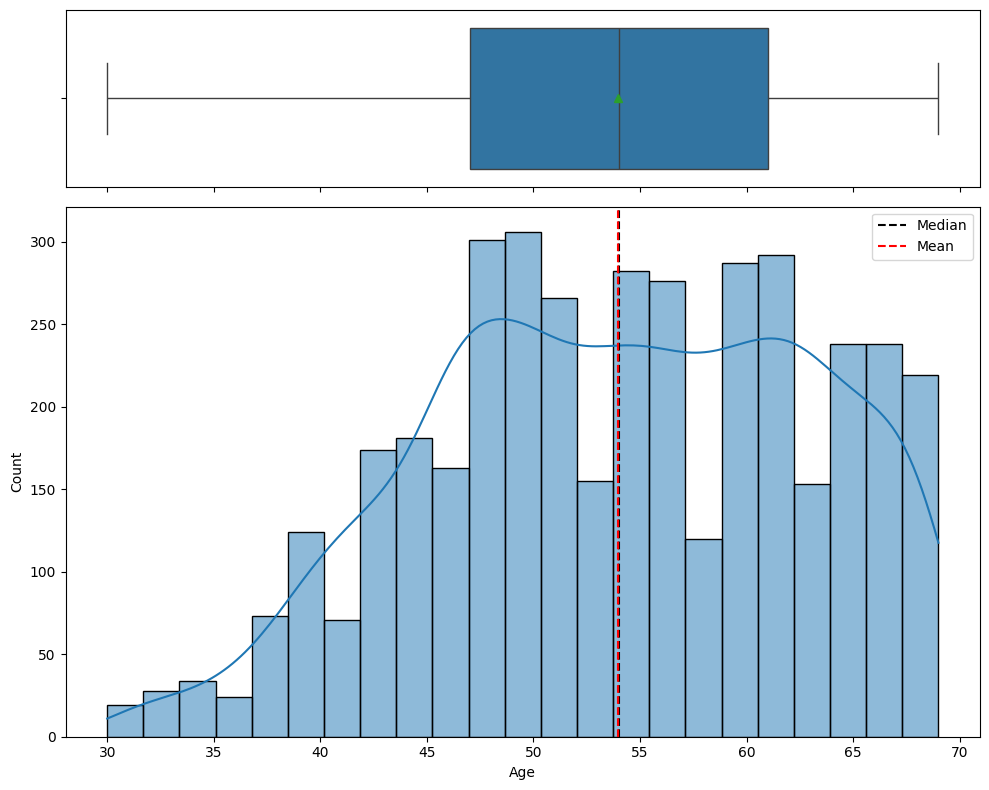

In [22]:
hist_boxplot('Age')

* Both median and mean age is close to 55.
* The majority of patients are between the age of 48 to 60, indicating age may be a significant risk factor for breast cancer.

**Tumor Size**

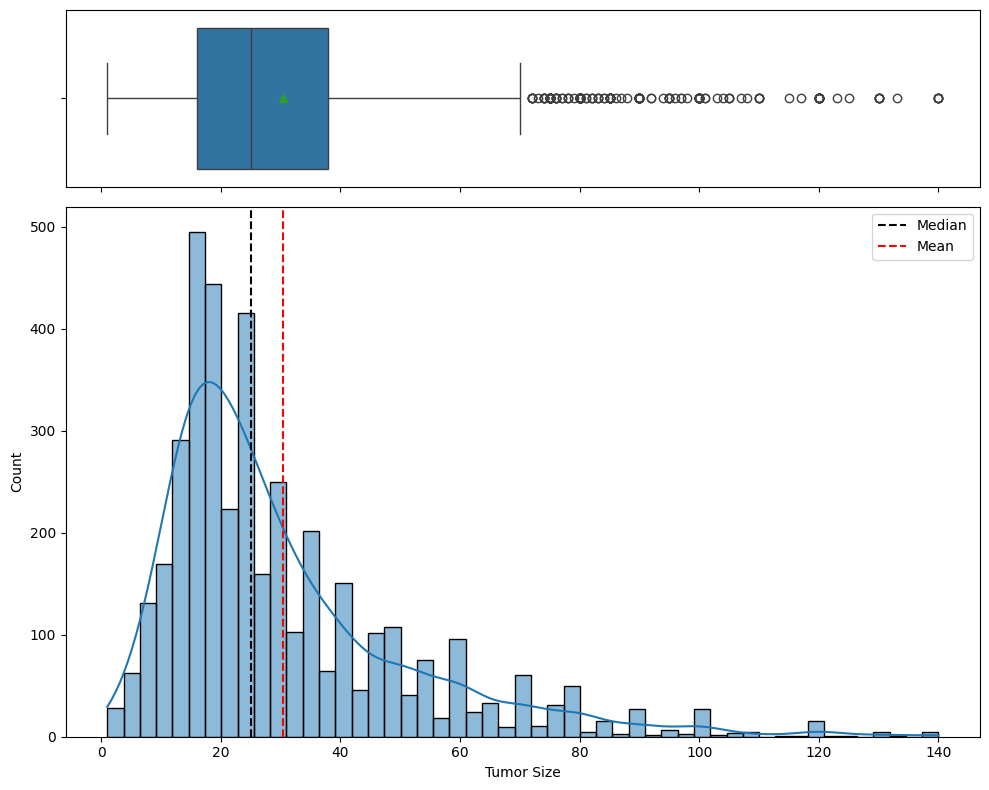

In [23]:
hist_boxplot('Tumor Size')

* There are some outliers for tumor size over 60, these patients are likely dead patients.
* The majority of patients have tumor size from 16 to 38, indicating size of the tumor for dead patients may be much bigger than alive patients.

**Regional Node Examined**

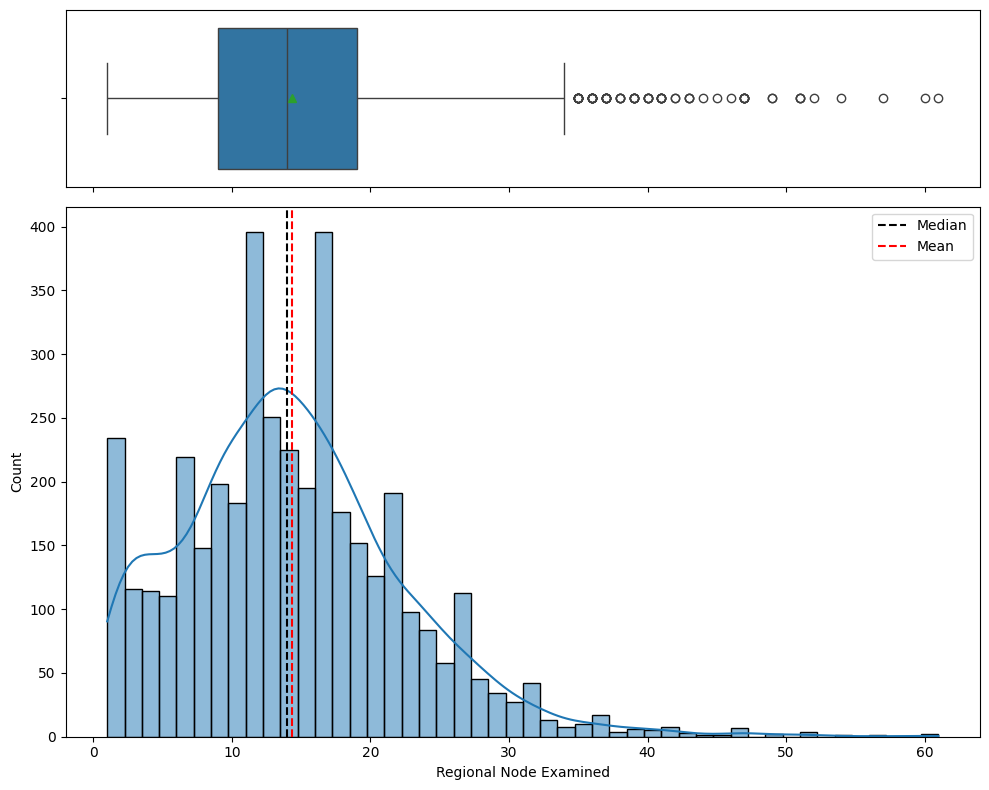

In [24]:
hist_boxplot('Regional Node Examined')

* The majority of patients have regional node examined from approximately 9 to 19, some patients have over 40 nodes examined.

* Since the 'Regional node examined' means the total number of lymph nodes surgically removed and examined regardless of whether they have cancer, the larger number of examined node does not directly imply that patient is dead.

**Regional Node Positive**

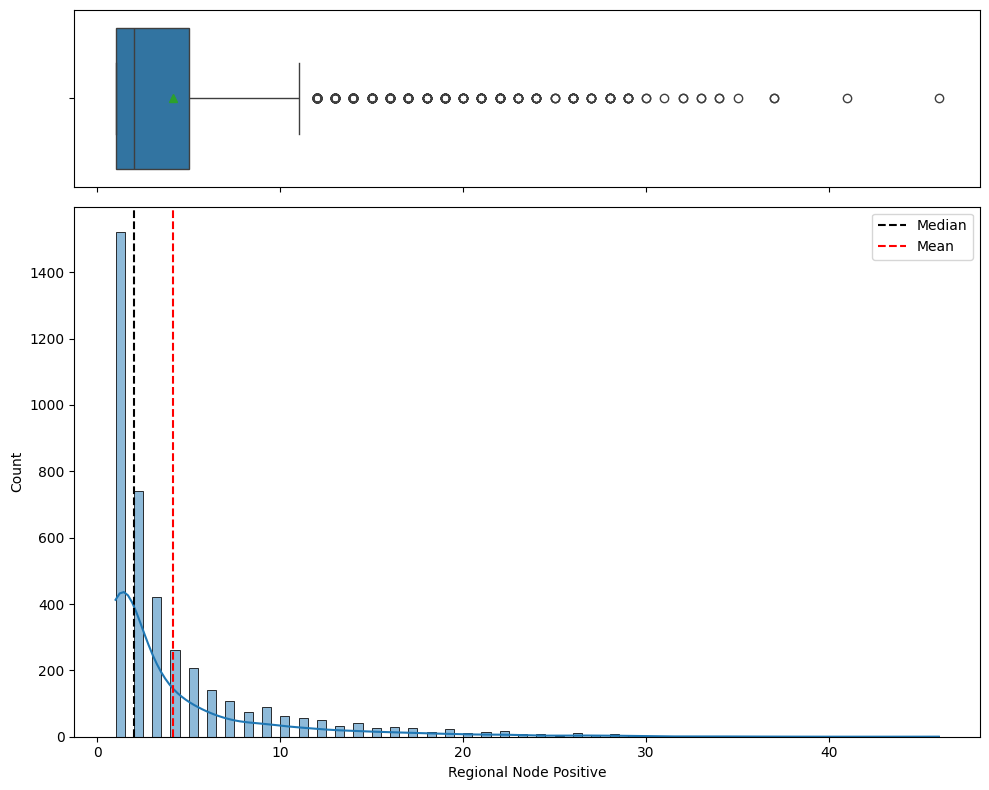

In [25]:
hist_boxplot('Regional Node Positive')

* The vast majority of the patients have relatively small number of positve regional node with cancer as 75th percentile of the patients have 5 positive nodes while there are patients with over 40 positive nodes, implying dead patients may have more positive nodes than others.

**Survival Months**

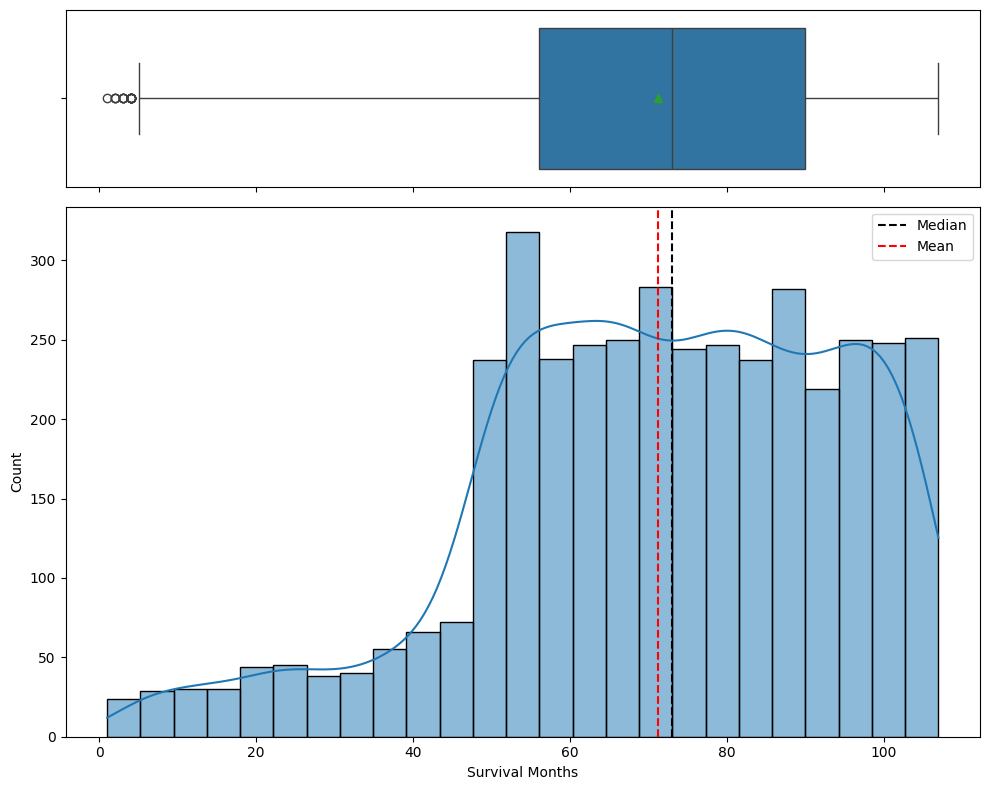

In [26]:
hist_boxplot('Survival Months')

* The majority of patients survive approximately 55 to 90 months.
* There is a steep increase after approximatley 50 months, indicating alive patients may generally live more than 50 months.

### b) Categorical Features

In [27]:
# Function to display a countplot with percentage labels for a categorical variable
def labeled_barplot(var):
    """
    Visualizes a labeled barplot with percentage for a given categorical variable.

    Parameters:
    - var: Column name of the categorical variable for visualization.

    Output:
    - A barplot with counts and percentage labels on each bar.
    """

    # Get the number of values in the variable and set the figure size based on the number
    count = df[var].nunique()
    plt.figure(figsize=(count + 3, 6))

    # Create the countplot with bars ordered by frequency
    ax = sns.countplot(data=df, x = var, order = df[var].value_counts().index[:], palette = 'viridis', hue = var)

    # Total number of records to calculate percentages
    total = len(df[var])

    # Loop through each bar to add percentage labels on top
    for p in ax.patches:
        # Calculate percentage of each category relative to total
        label = '{:.1f}%'.format(100 * p.get_height() / total)

        # Get the x and y coordinates for placing the label
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()

        # Annotate the plot with the percentage label slightly above each bar
        ax.annotate(label, (x, y), ha='center', va='center', xytext=(0, 6),
                    size=12, textcoords='offset points')

    # Show the final plot
    plt.show()

**Race**

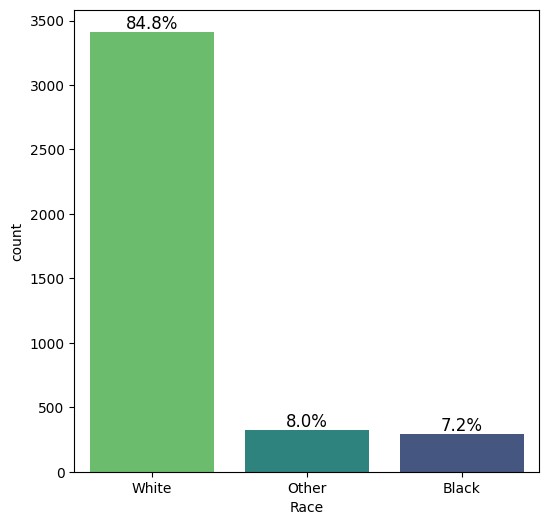

In [28]:
labeled_barplot('Race')

* Among the breast cancer patients (dead or alive), white population shows dominating figure, indicating white race may be more vulnerable than other races.

**Marital Status**

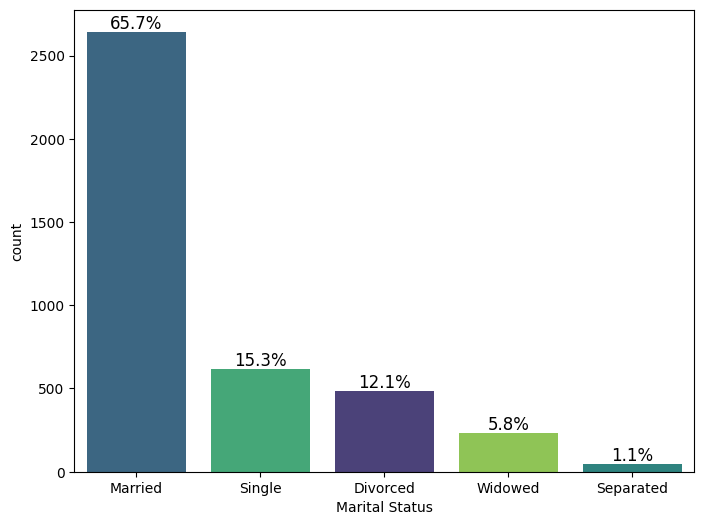

In [29]:
labeled_barplot('Marital Status')

* Among the breast cancer patients (dead or alive), married women seems to be dominating figure, implying breast cancer may have coorelation from the stress from the marriage.

**T Stage**

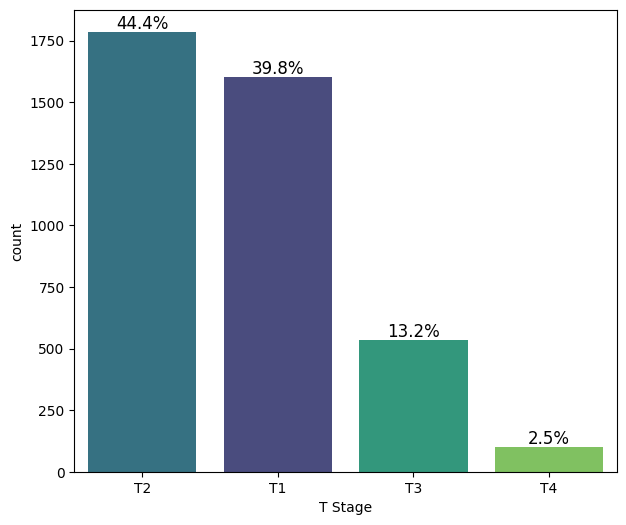

In [30]:
labeled_barplot('T Stage')

* The vast majority of T stages over 80 percent are in T1 and T2 stage.
* Very few patients are in the advanced T4 stage.

**N Stage**

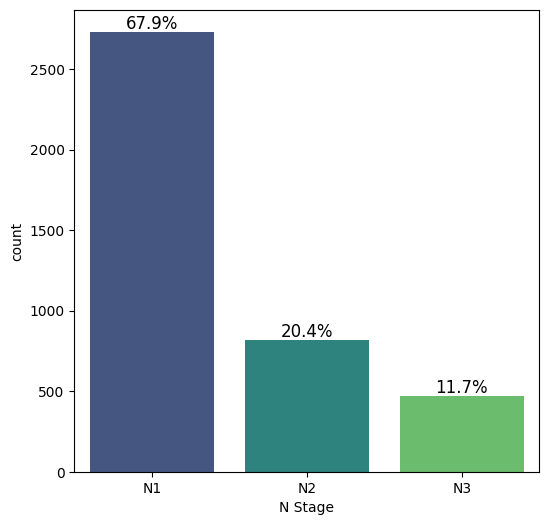

In [31]:
labeled_barplot('N Stage')

* N1 is most common, indicating limited node involvement.

**6th Stage**

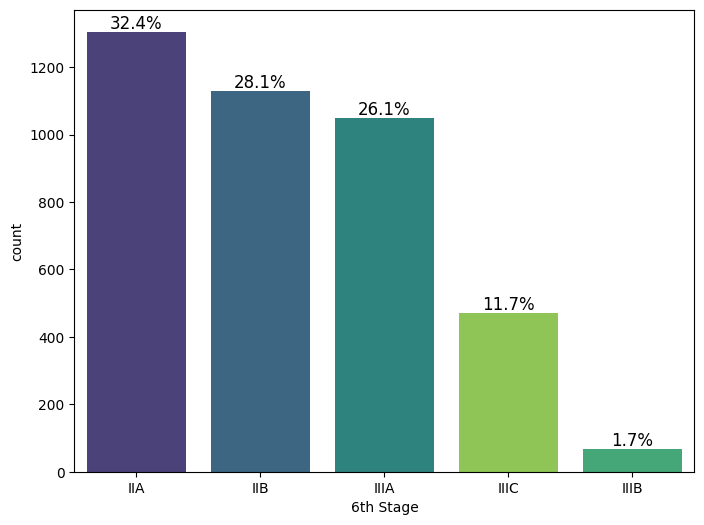

In [32]:
labeled_barplot('6th Stage')

* Most patients are in intermediate stage cancer such as Stage IIA, IIB, or IIIA.

**Grade**

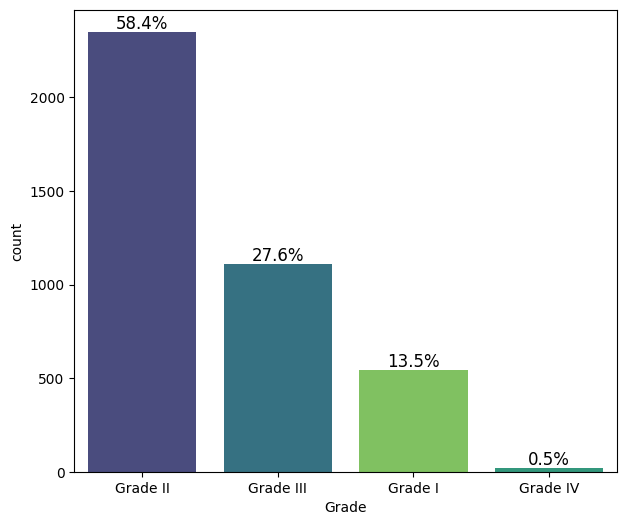

In [33]:
labeled_barplot('Grade')

* The majority of tumors are moderately differentiated (Grade II).
* Undifferentiated (Grade IV) is rare with 0.5 percent.

**A Stage**

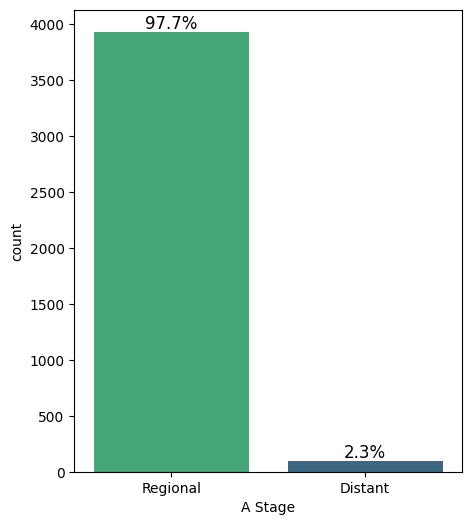

In [34]:
labeled_barplot('A Stage')

* The vast majority of 97.7 percent are regional cases, meaning the cancer has spread to nearby tissues or nodes.

**Estrogen Status**

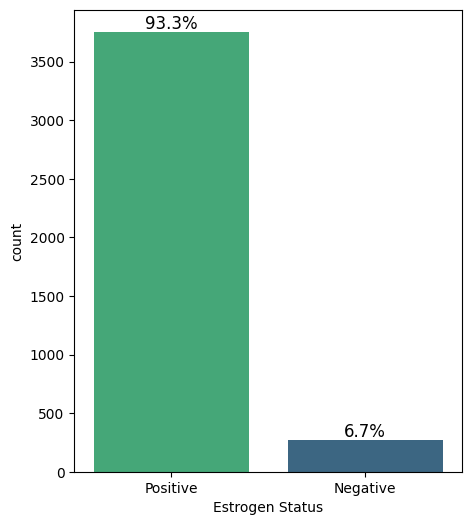

In [35]:
labeled_barplot('Estrogen Status')

* 93.3 percent of tumors are ER-positive, suggesting strong possibility for hormone therapy for patients.

**Progesterone Status**

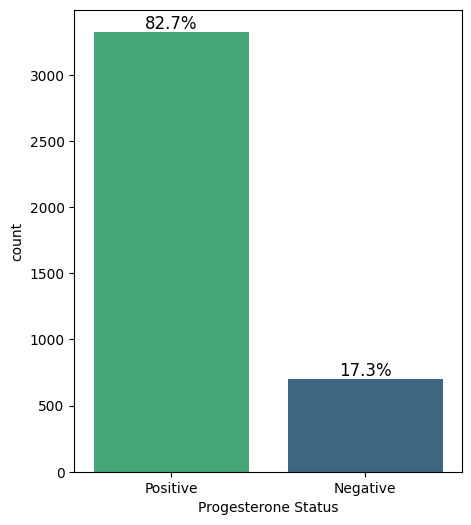

In [36]:
labeled_barplot('Progesterone Status')

* 82.7 percent are PR-positive, consistent with favorable hormonal therapy.

**Status**

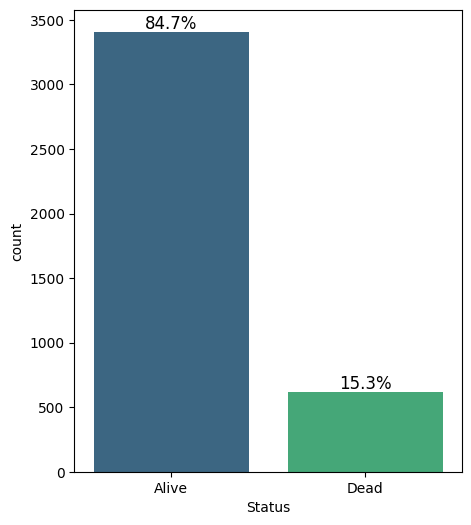

In [37]:
labeled_barplot('Status')

* The target variable of the dataset, showing the imbalanceness of the data.

### Bivariate Analysis

### a) Numeric features & Status

In [38]:
# Function to plot correlation between status and numeric variables
def distribution_plot(predictor, target):
  """
  Visualizes the distribution of a numeric variable (predictor) across different classes of the target variable.

  Parameters:
  - predictor: Name of the numeric predictor variable.
  - target: Name of the binary target variable (Status).

  Output:
  - Histogram for Alive group
  - Histogram for Dead group
  - Boxplot with outliers
  - Boxplot without outliers
  """
  # Create a 2x2 grid for subplots with specified figure size
  fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (14, 8))

  # Extract unique classes from the target variable
  target_uniq = df[target].unique()

  # Histogram of predictor that counts alive patients
  axs[0, 0].set_title(f'Histogram Distribution of {target} (Alive)')
  sns.histplot(data = df[df[target] == target_uniq[0]], x = predictor, kde = True, ax = axs[0, 0], color = 'teal', stat = 'density')

  # Histogram of predictor that counts dead patients
  axs[0, 1].set_title(f'Histogram Distribution of {target} (Dead)')
  sns.histplot(data = df[df[target] == target_uniq[1]], x = predictor, kde = True, ax = axs[0, 1], color = 'orange', stat = 'density')

  # Boxplot of predictor and target with outliers
  axs[1, 0].set_title(f'Boxplot of {target} by {predictor}')
  sns.boxplot(data = df, x = target, y = predictor, ax = axs[1, 0], palette = 'pastel', hue = target, legend = False, showmeans = True)

  # Boxplot of predictor and target without outliers
  axs[1, 1].set_title(f'Boxplot of {target} by {predictor} without outliers')
  sns.boxplot(data = df, x = target, y = predictor, ax = axs[1, 1], palette = 'pastel', showfliers = False, hue = target, legend = False, showmeans = True)

  # Improve layout and display
  plt.tight_layout()
  plt.show()

**Age & Status**

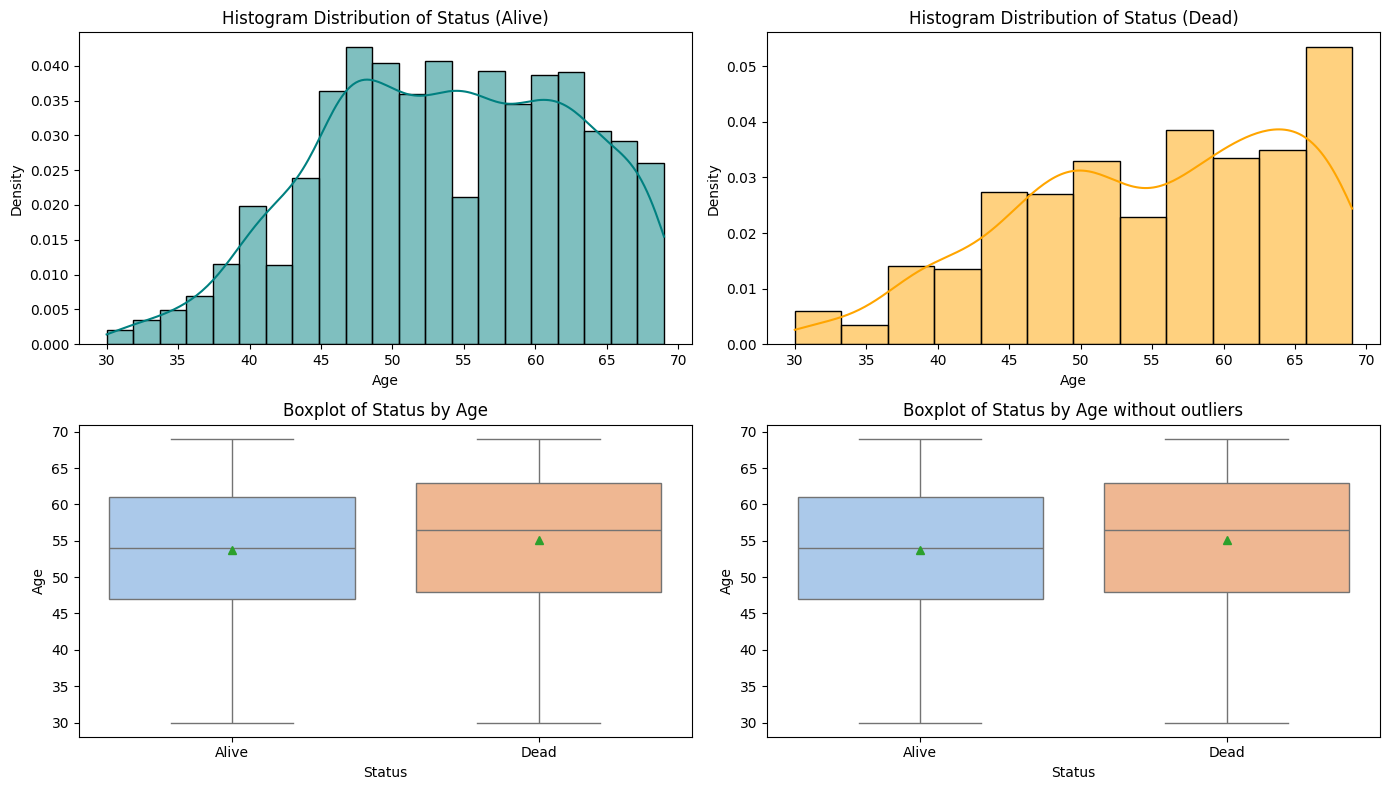

In [39]:
distribution_plot('Age', 'Status')

* Both groups show growth after age 40.
* Median and mean age are slightly higher in the dead group.
* No significant outliers.

**Tumor Size & Status**

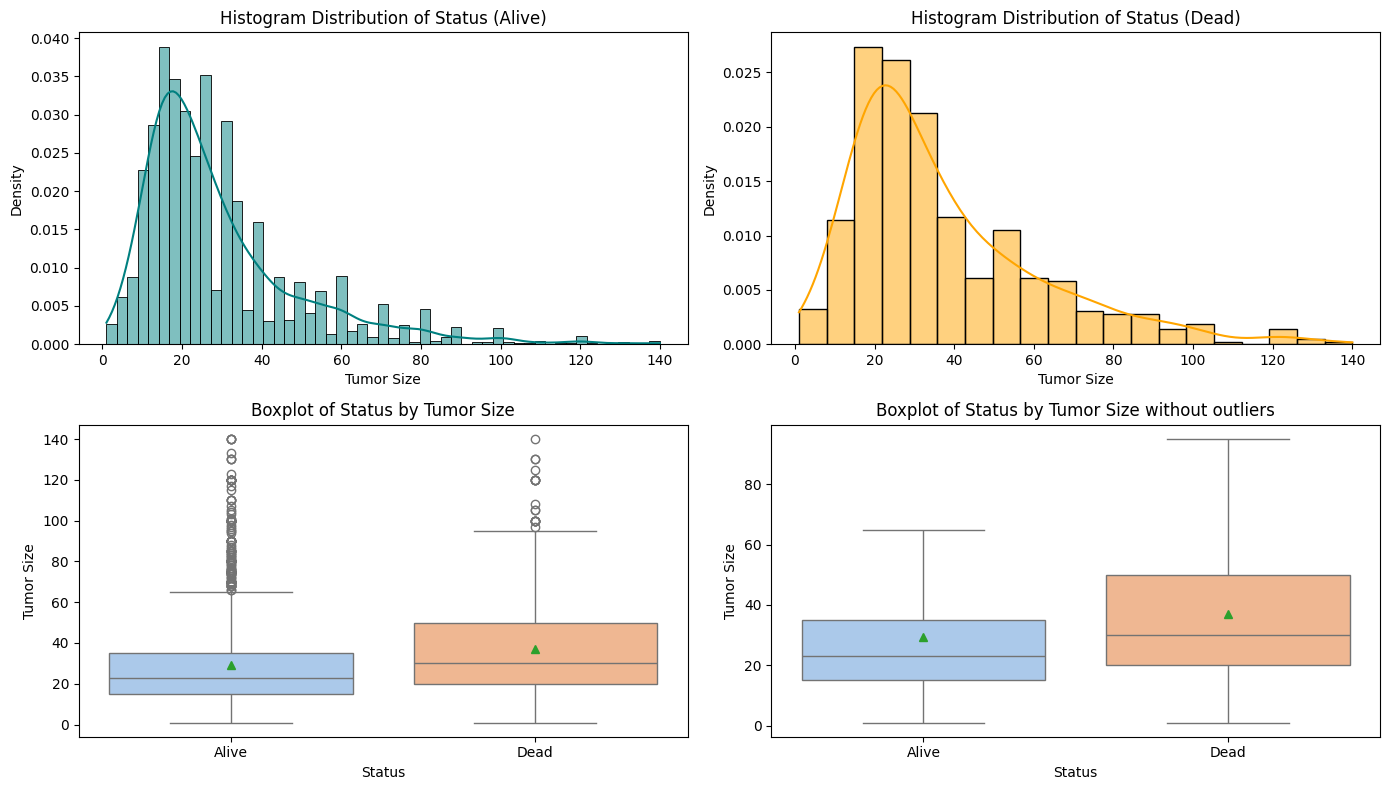

In [40]:
distribution_plot('Tumor Size', 'Status')

* Alive patients have smaller tumor sizes, peaking around 15–20 mm and dead patients tend to have larger tumors.

* Median and mean tumor size are both higher in the dead group, indicating larger tumor sizes overall.

* The Alive group has many outliers, but the majority of the values remain lower than the dead group.

**Regional Node Examined vs Status**

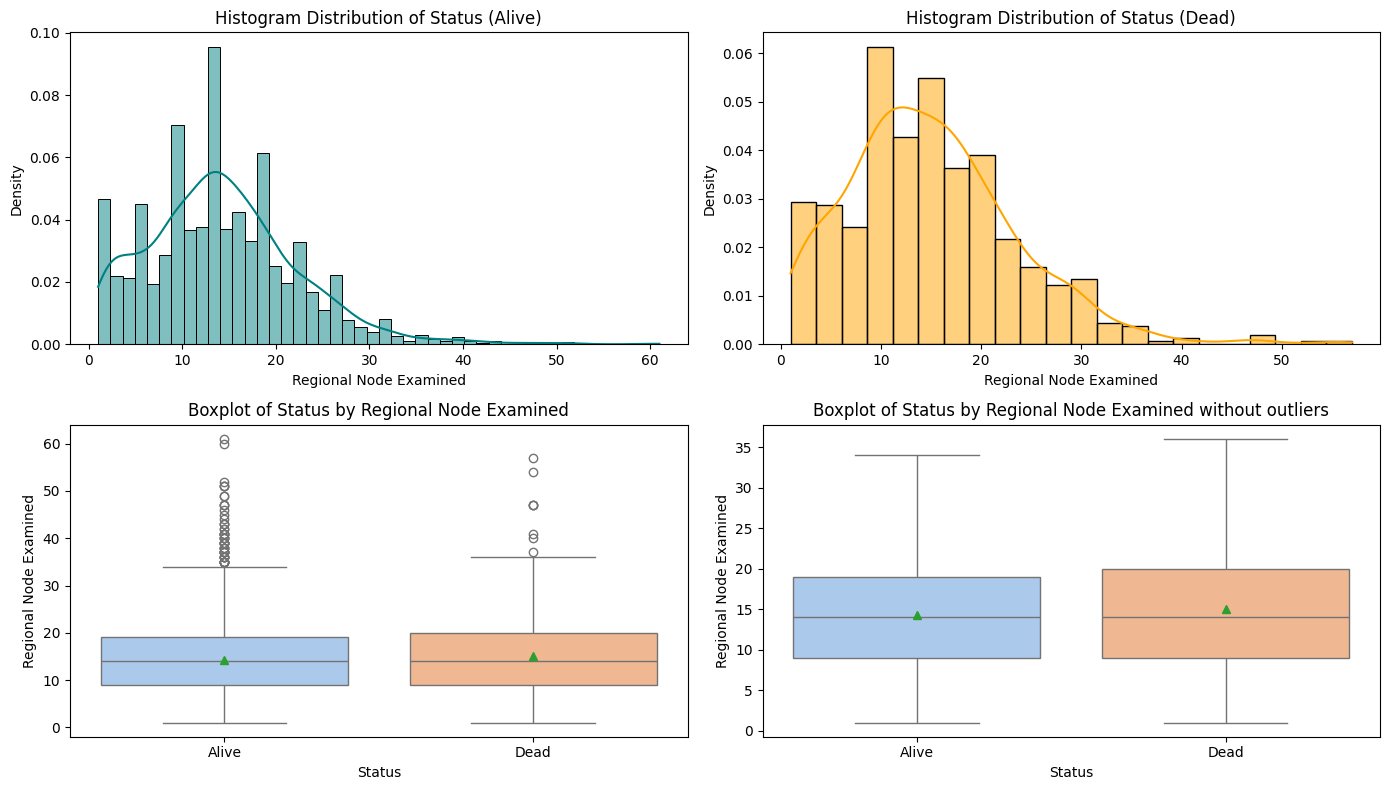

In [41]:
distribution_plot('Regional Node Examined', 'Status')

* Both groups are right-skewed, with majority of patients having 10–20 nodes examined.
* Dead patients slightly more often had more nodes examined.
* Distribution is similar, but the Alive group has more high outliers.

**Regional Node Positive & Status**

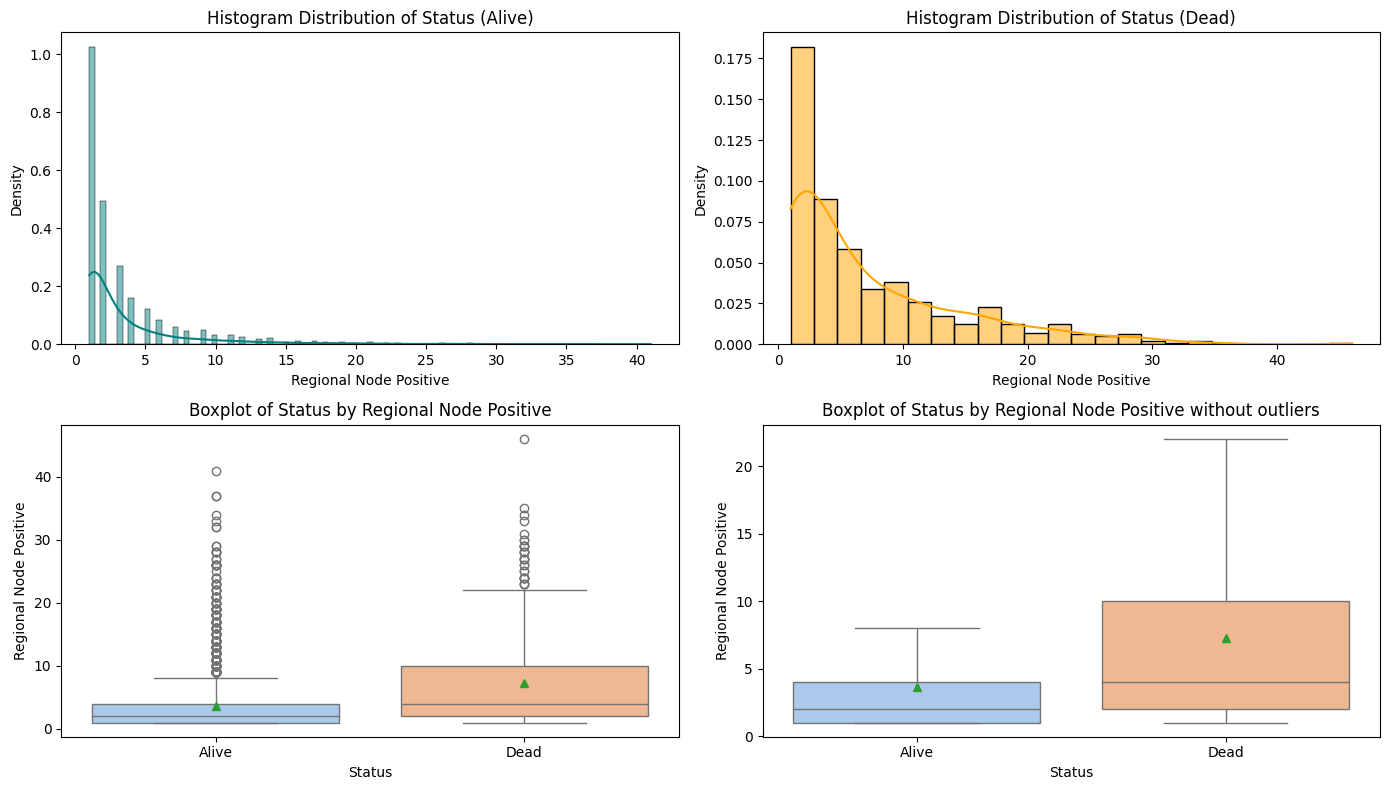

In [42]:
distribution_plot('Regional Node Positive', 'Status')

* Alive patients mostly have 5- positive nodes and dead patients show a wider spread, having more 5+ positive nodes.

* Median, mean, and upper range are all higher in the dead group.

**Survival Months vs Status**

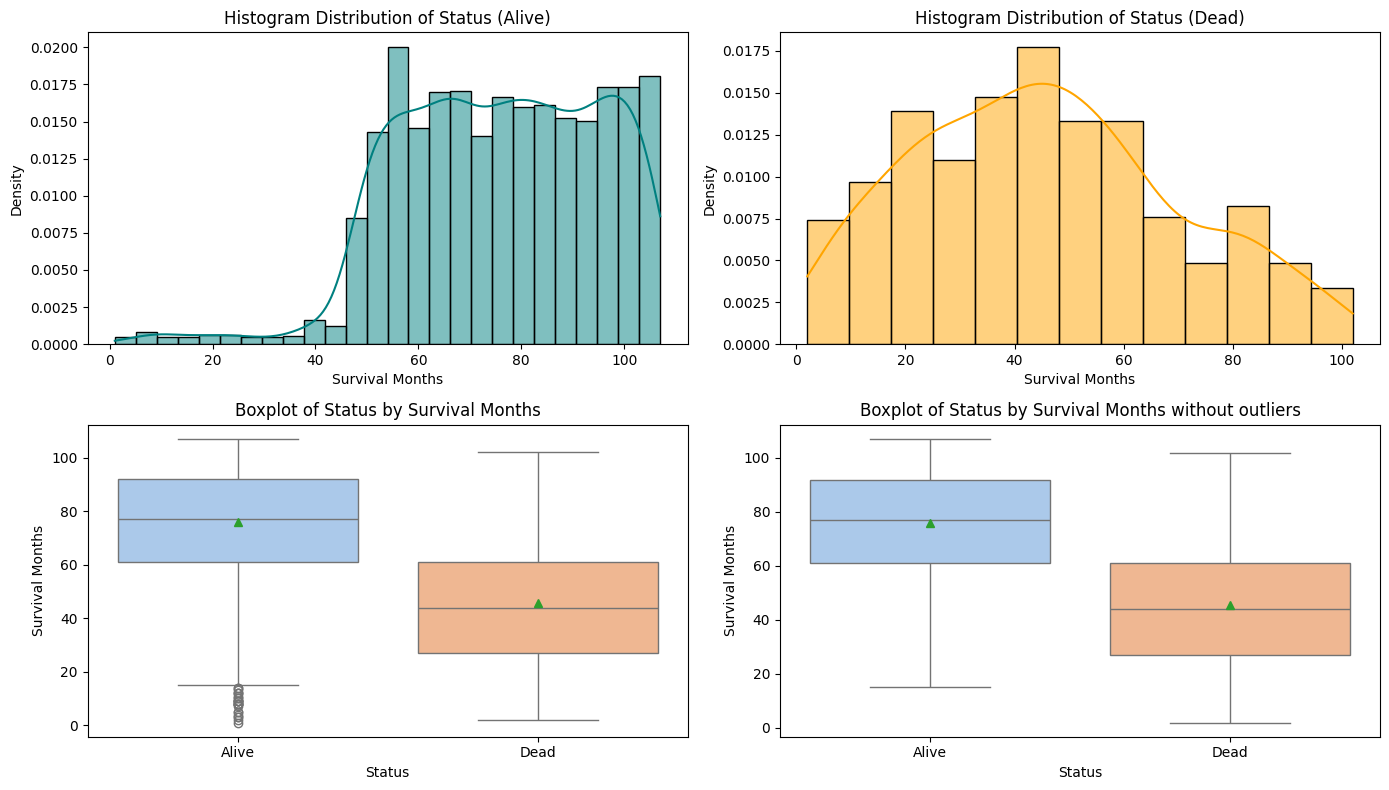

In [43]:
distribution_plot('Survival Months', 'Status')

* Alive patients have consistently high survival durations, mostly 60+ months, with a sharp rise after 40 months.

* Dead patients peak around 40–60 months and decline, showing shorter overall survival.

* Alive group has higher median and mean survival.

### b) Categorical features & Status

In [44]:
# Function to plot the correlation status and categorical variables
def stacked_barplot(predictor, target):
    """
    Plots a stacked bar chart showing the distribution of a categorical predictor
    variable across the levels of a binary target variable.

    Parameters:
    - predictor: Name of the categorical predictor variable.
    - target: Name of the binary target variable (Status).

    Output:
    - Prints a frequency table of predictor vs. target
    - Displays a normalized stacked bar plot
    """
    # Number of unique categories in the predictor
    count = df[predictor].nunique()

    # Identify the minority class to sort the plot accordingly
    sorter = df[target].value_counts().index[-1]

    # Print frequency table
    freq_table = pd.crosstab(df[predictor], df[target], margins = True).sort_values(by = sorter, ascending = False)
    print(freq_table, '\n')

    # Create normalized crosstab for plotting
    normalized_table = pd.crosstab(df[predictor], df[target], normalize = "index").sort_values(by = sorter, ascending = False)

    # Set up figure size dynamically
    plt.figure(figsize=(count + 4, 5))

    # Generate the stacked barplot
    ax = normalized_table.plot(kind='bar', stacked=True)

    # Display djustments
    plt.title(f"Distribution of {target} by {predictor}")
    plt.xlabel(predictor)
    plt.ylabel("Proportion")
    plt.xticks(rotation = 0)
    plt.legend(title = target, loc = 'upper left', bbox_to_anchor = (1, 1))
    plt.subplots_adjust(right = 0.8)

    # Improve layout and display
    plt.tight_layout()
    plt.show()

**Race & Status**

Status  Alive  Dead   All
Race                     
All      3408   616  4024
White    2903   510  3413
Black     218    73   291
Other     287    33   320 



<Figure size 700x500 with 0 Axes>

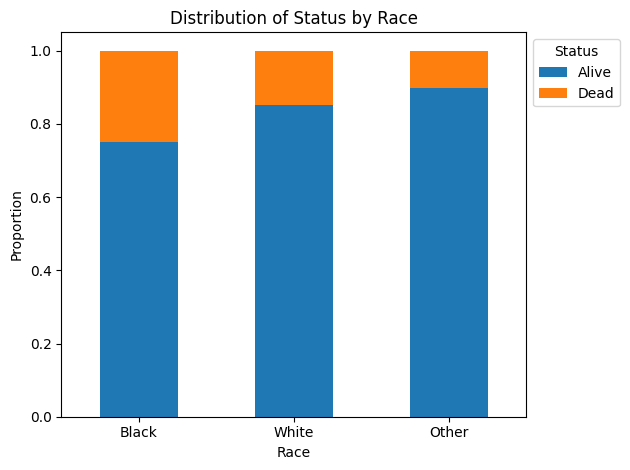

In [45]:
stacked_barplot('Race', 'Status')

* All groups show majority of patients are alive.
* Black patients have a higher proportion of deaths compared to other groups.

**Marital Status & Status**

Status          Alive  Dead   All
Marital Status                   
All              3408   616  4024
Married          2285   358  2643
Single            511   104   615
Divorced          396    90   486
Widowed           186    49   235
Separated          30    15    45 



<Figure size 900x500 with 0 Axes>

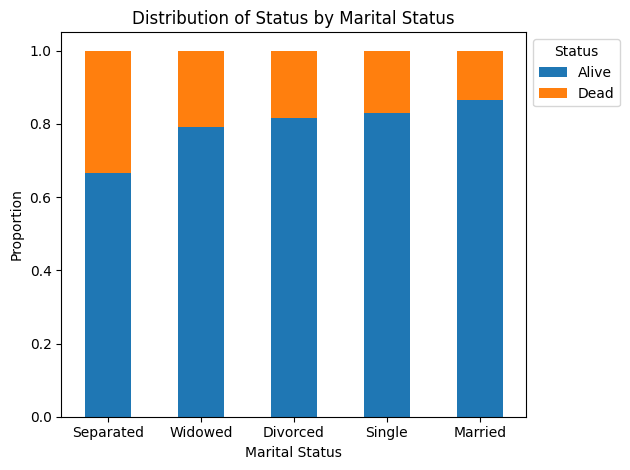

In [46]:
stacked_barplot('Marital Status', 'Status')

* Married patients show the highest survival proportion.

* Separated and widowed individuals have notably higher death rates, suggesting lack of social/family support may impact survival.

**T Stage & Status**

Status   Alive  Dead   All
T Stage                   
All       3408   616  4024
T2        1483   303  1786
T1        1446   157  1603
T3         417   116   533
T4          62    40   102 



<Figure size 800x500 with 0 Axes>

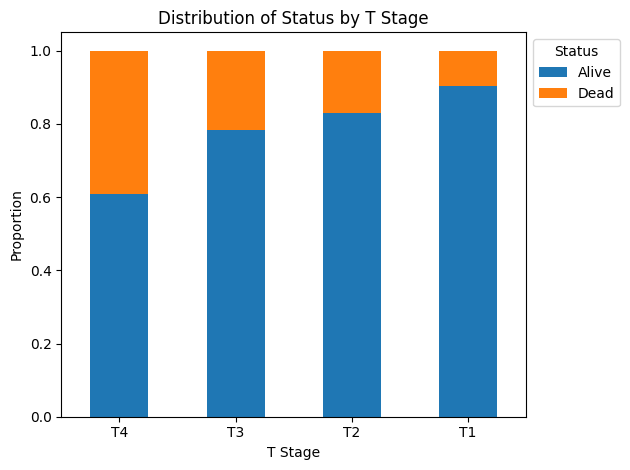

In [47]:
stacked_barplot('T Stage', 'Status')

* T4 stage shows approximatley 40 percent of death rate.
* Mortality rate increases with higher T stages, suggesting strong correlation between T Stage and Status.

**N Stage & Status**

Status   Alive  Dead   All
N Stage                   
All       3408   616  4024
N1        2462   270  2732
N3         291   181   472
N2         655   165   820 



<Figure size 700x500 with 0 Axes>

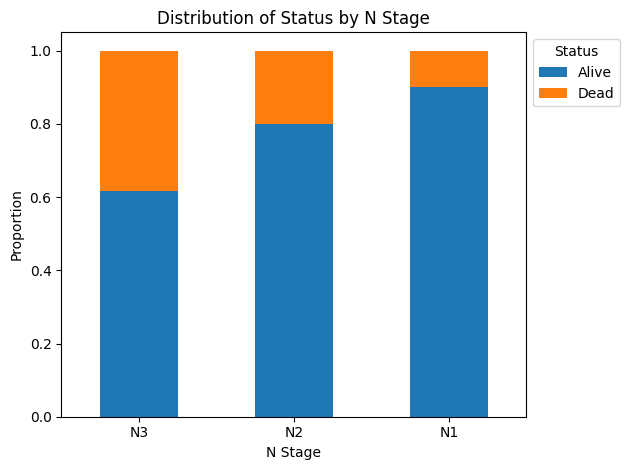

In [48]:
stacked_barplot('N Stage', 'Status')

* N3 stage shows approximatley 40 percent of death rate.
* Mortality rate increases with higher N stages, suggesting strong correlation between N Stage and Status.

**6th Stage & Status**

Status     Alive  Dead   All
6th Stage                   
All         3408   616  4024
IIIA         866   184  1050
IIIC         291   181   472
IIB          995   135  1130
IIA         1209    96  1305
IIIB          47    20    67 



<Figure size 900x500 with 0 Axes>

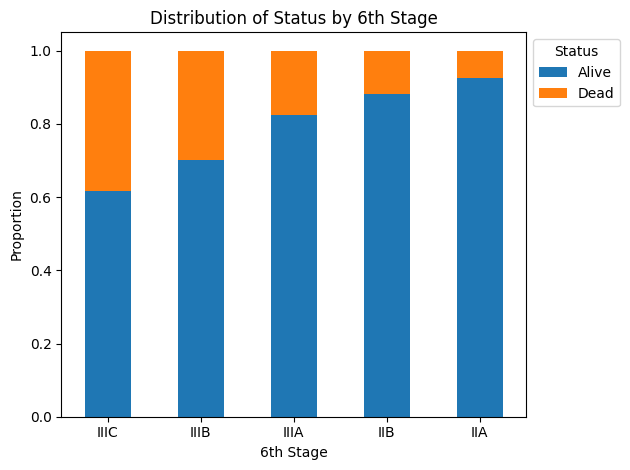

In [49]:
stacked_barplot('6th Stage', 'Status')

* IIIC stage shows approximatley 40 percent of death rate.
* Mortality rate increases with higher 6th stages, suggesting strong correlation between 6th Stage and Status.

**Grade & Status**

Status     Alive  Dead   All
Grade                       
All         3408   616  4024
Grade II    2046   305  2351
Grade III    848   263  1111
Grade I      504    39   543
Grade IV      10     9    19 



<Figure size 800x500 with 0 Axes>

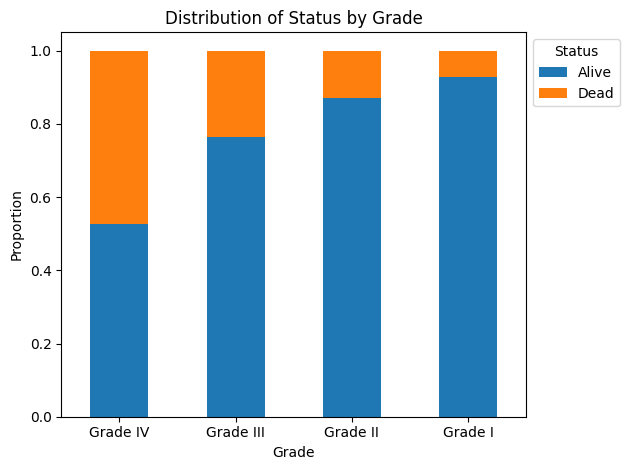

In [50]:
stacked_barplot('Grade', 'Status')

* Grade IV (Undifferentiated) shows approximatley 50 percent of death rate.
* Mortality rate increases with higher Grade level, suggesting strong correlation between Grade and Status.

**A Stage & Status**

Status    Alive  Dead   All
A Stage                    
All        3408   616  4024
Regional   3351   581  3932
Distant      57    35    92 



<Figure size 600x500 with 0 Axes>

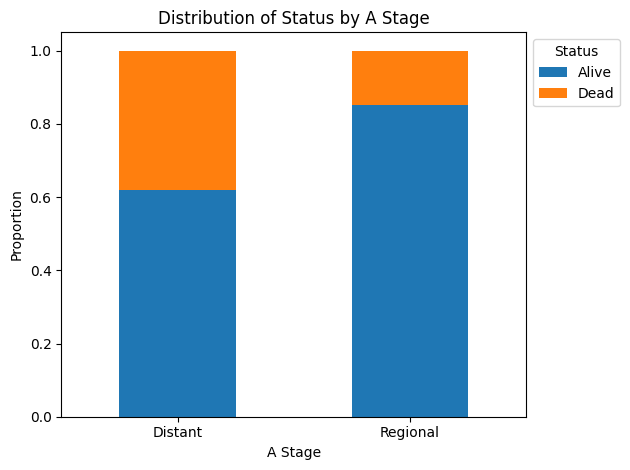

In [51]:
stacked_barplot('A Stage', 'Status')

* Patients with distant stage shows much higher death rate than regional stage.

**Estrogen Status & Status**

Status           Alive  Dead   All
Estrogen Status                   
All               3408   616  4024
Positive          3247   508  3755
Negative           161   108   269 



<Figure size 600x500 with 0 Axes>

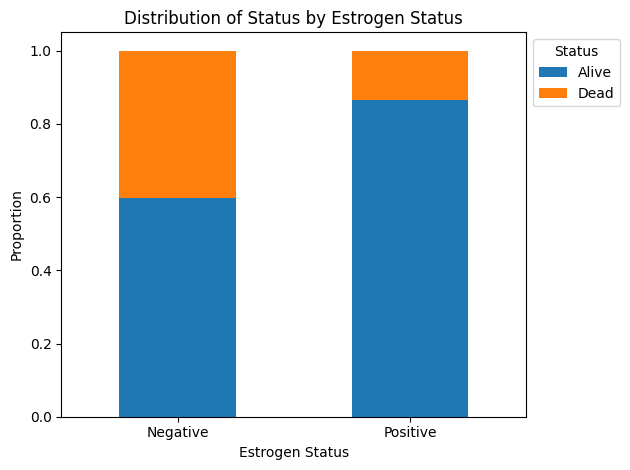

In [52]:
stacked_barplot('Estrogen Status', 'Status')

* Patients with ER-negative tumors have a much higher mortality rate.

**Progesterone Status & Stats**

Status               Alive  Dead   All
Progesterone Status                   
All                   3408   616  4024
Positive              2914   412  3326
Negative               494   204   698 



<Figure size 600x500 with 0 Axes>

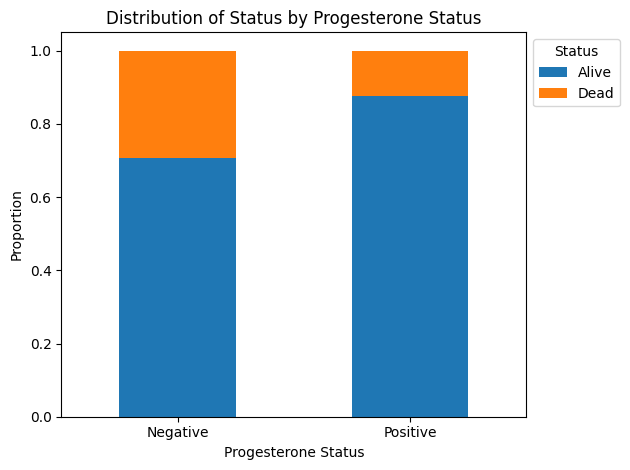

In [53]:
stacked_barplot('Progesterone Status', 'Status')

* PR-negative patients have a significantly higher death rate.

## Hypothesis Testing

* Hypothesis testing will help discover whether observed differences in features between alive vs dead groups are statistically significant.

In [54]:
# Convert Status to binary (1 for Alive, 0 for Dead)
df['Status'] = df['Status'].apply(lambda x: 1 if x == 'Alive' else 0).astype(int)
df['Status'].value_counts(1)

,proportion
Status,
1,0.846918
0,0.153082


In [55]:
# Identify categorical and numerical columns
cat_cols = df.select_dtypes(include = 'category').columns.tolist()
num_cols = df.select_dtypes(include = np.number).columns.drop('Status').tolist()

### **Base Hypothesis for Statistical Testing**

To understand whether specific features differ significantly between patients who are alive and those who are dead, we define the following hypotheses:

* **Null Hypothesis (H₀):** There is no significant difference in the selected features between patients who are alive and those who are dead.
* **Alternative Hypothesis (H₁):** There is a significant difference in the selected features between patients who are alive and those who are dead.

### **Choice of Tests**

Since we will be employing machine learning and deep learning models that do not rely on traditional statistical assumptions (such as normality or homoscedasticity), we will use non-parametric tests, which do not require strong distributional assumptions:

* **Mann–Whitney U Test**: Applied to numeric variables to assess whether the distribution of values differs between the two outcome groups (Alive vs. Dead).

* **Chi-square Test of Independence**: Applied to categorical variables to determine whether there is a significant association between the variable and patient status.

These tests may provide statistically robust insights beyond the visualizations.

### Mann–Whitney U Test

In [56]:
def mannwhitney_test(df, predictor, target, group1_val, group2_val):
    """
    Perform Mann–Whitney U test on a numeric column between two groups.

    Parameters:
    - df: DataFrame containing the data
    - numeric_col: the name of the numeric column to compare
    - group_col: the column defining the two groups (must be binary)
    - group1_val: value representing the first group in group_col (alive)
    - group2_val: value representing the second group in group_col (dead)

    Output:
    - U statistics and p-values for numeric features
    """
    group1 = df[df[target] == group1_val][predictor]
    group2 = df[df[target] == group2_val][predictor]

    u_stat, p_val = mannwhitneyu(group1, group2, alternative = 'two-sided')
    print(f"Mann–Whitney U Test for {predictor}: U = {u_stat:.2f}, p-value = {p_val:.5f}")

In [57]:
for col in num_cols:
    mannwhitney_test(df, predictor = col, target = 'Status', group1_val = 1, group2_val = 0)
    print('-' * 70)

Mann–Whitney U Test for Age: U = 944505.00, p-value = 0.00007
----------------------------------------------------------------------
Mann–Whitney U Test for Tumor Size: U = 813236.00, p-value = 0.00000
----------------------------------------------------------------------
Mann–Whitney U Test for Regional Node Examined: U = 1001152.00, p-value = 0.06730
----------------------------------------------------------------------
Mann–Whitney U Test for Regional Node Positive: U = 692561.50, p-value = 0.00000
----------------------------------------------------------------------
Mann–Whitney U Test for Survival Months: U = 1748716.00, p-value = 0.00000
----------------------------------------------------------------------


* According to the Mann-Whitney U Test, Regional Node Examined did not show a statistically significant difference (p > 0.05), and thus we fail to reject the null hypothesis for this variable.

* These results suggest that factors such as age, tumor burden, and node involvement are potentially important in influencing survival outcomes, whereas the number of regional nodes examined alone may not be a discriminative factor.

### Chi-Squared Test

In [58]:
def chi_squared_test(df, predictor, target):
    """
    Performs the Chi-Squared Test of Independence between a categorical feature and the target.

    Parameters:
    - df: DataFrame containing the data
    - feature_name: Name of the categorical feature column
    - target_col: Name of the binary target column (Status)

    Output:
    - Test statistic and p-values of categorical columns
    """
    contingency = pd.crosstab(df[predictor], df[target])
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"Chi-Square Test for {predictor}: Chi² = {chi2:.2f}, p-value = {p:.5f}")

In [59]:
for col in cat_cols:
    chi_squared_test(df, predictor = col, target = 'Status')
    print('-' * 70)

Chi-Square Test for Race: Chi² = 27.97, p-value = 0.00000
----------------------------------------------------------------------
Chi-Square Test for Marital Status: Chi² = 28.26, p-value = 0.00001
----------------------------------------------------------------------
Chi-Square Test for T Stage: Chi² = 103.48, p-value = 0.00000
----------------------------------------------------------------------
Chi-Square Test for N Stage: Chi² = 269.93, p-value = 0.00000
----------------------------------------------------------------------
Chi-Square Test for 6th Stage: Chi² = 281.65, p-value = 0.00000
----------------------------------------------------------------------
Chi-Square Test for Grade: Chi² = 112.56, p-value = 0.00000
----------------------------------------------------------------------
Chi-Square Test for A Stage: Chi² = 35.76, p-value = 0.00000
----------------------------------------------------------------------
Chi-Square Test for Estrogen Status: Chi² = 135.16, p-value = 0.0000

* According to Chi-Square Test, it shows a statistically significant difference (p > 0.05) for every categorical variables, therefiore, rejecting the null hypothesis.

* These results suggest that categorical features are potentially important in influencing survival outcomes.

* It seems that there is no valid reason to drop features according to the statistical tests.

## Data Preprocessing

In [60]:
# Separate ordinal and nominal categorical features
ordinal_cat = ['T Stage', 'N Stage', '6th Stage', 'Grade']
nominal_cat = [col for col in cat_cols if col not in ordinal_cat]

In [61]:
# Divide the target and predictor
X_raw = df.drop('Status', axis=1)
y = df['Status']

# Create train/validation/test splits
X_temp_raw, X_test_raw, y_temp, y_test = train_test_split(
    X_raw, y, test_size = 0.2, random_state = 1, stratify = y
)
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_temp_raw, y_temp, test_size = 0.25, random_state = 1, stratify = y_temp
)

print(f"Raw splits - Train: {X_train_raw.shape}, Validation: {X_val_raw.shape}, Test: {X_test_raw.shape}")

Raw splits - Train: (2414, 14), Validation: (805, 14), Test: (805, 14)


In [62]:
# Set custom order for ordinal categorical variables
custom_order = [
    ['T1', 'T2', 'T3', 'T4'],  # T Stage
    ['N1', 'N2', 'N3'],        # N Stage
    ['IIA', 'IIB', 'IIIA', 'IIIB', 'IIIC'],  # 6th Stage
    ['Grade I', 'Grade II', 'Grade III','Grade IV']  # Grade
]

In [63]:
# Initialize encoders
ordinal_encoder = OrdinalEncoder(categories = custom_order)
onehot_encoder = OneHotEncoder(sparse_output = False, drop=None)

# fit encoders on training data only
ordinal_encoder.fit(X_train_raw[ordinal_cat])
onehot_encoder.fit(X_train_raw[nominal_cat])

OneHotEncoder(sparse_output=False)

* Since there are ordinal categorical variables, we set the custom order to have accurate results.

* Fit the encoders to training data only to avoid data leakage and have accurate results.

In [64]:
# Transform training data
X_train_ord = pd.DataFrame(
    ordinal_encoder.transform(X_train_raw[ordinal_cat]).astype(int),
    columns=ordinal_cat,
    index=X_train_raw.index
)
X_train_nom = pd.DataFrame(
    onehot_encoder.transform(X_train_raw[nominal_cat]).astype(int),
    columns=onehot_encoder.get_feature_names_out(nominal_cat),
    index=X_train_raw.index
)

In [65]:
# Transform validation data
X_val_ord = pd.DataFrame(
    ordinal_encoder.transform(X_val_raw[ordinal_cat]).astype(int),
    columns=ordinal_cat,
    index=X_val_raw.index
)
X_val_nom = pd.DataFrame(
    onehot_encoder.transform(X_val_raw[nominal_cat]).astype(int),
    columns=onehot_encoder.get_feature_names_out(nominal_cat),
    index=X_val_raw.index
)

In [66]:
# Transform test data
X_test_ord = pd.DataFrame(
    ordinal_encoder.transform(X_test_raw[ordinal_cat]).astype(int),
    columns=ordinal_cat,
    index=X_test_raw.index
)
X_test_nom = pd.DataFrame(
    onehot_encoder.transform(X_test_raw[nominal_cat]).astype(int),
    columns=onehot_encoder.get_feature_names_out(nominal_cat),
    index=X_test_raw.index
)

In [67]:
# Combine encoded features with numerical features
X_train = pd.concat([X_train_ord, X_train_nom, X_train_raw[num_cols]], axis = 1)
X_val = pd.concat([X_val_ord, X_val_nom, X_val_raw[num_cols]], axis = 1)
X_test = pd.concat([X_test_ord, X_test_nom, X_test_raw[num_cols]], axis = 1)

print(f"Processed splits - Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Processed splits - Train: (2414, 23), Validation: (805, 23), Test: (805, 23)


In [68]:
# scale numerical features (fit on training, transform on all)
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

* Now our data preprocessing is completed (encoding - scaling pipeline).

## Quick Model Evaulation

In [70]:
y_train.value_counts(1)

,proportion
Status,
1,0.846727
0,0.153273


* As the dataset is imbalanced, we will set the class weights for different groups of machine learning techniques for quick model evaluation.

* In the pipeline we could have used oversampling techniques such as SMOTE, but manullay setting the class and sample weight showed better results in F1 score overall.

### Group 1

In [72]:
class_weight = 'balanced'

models_group1 = [
    ('Logistic Regression', LogisticRegression(random_state = 1, class_weight = class_weight)),
    ('SVM', SVC(random_state = 1, class_weight = class_weight)),
    ('Random Forest', RandomForestClassifier(random_state = 1, class_weight = class_weight)),
    ('Extra Trees', ExtraTreesClassifier(random_state = 1, class_weight = class_weight)),
    ('Decision Tree', DecisionTreeClassifier(random_state = 1, class_weight = class_weight)),
]

print("\nGROUP 1: Model Performance Comparisons\n")
for name, model in models_group1:
    kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)
    scores = cross_val_score(model, X_train, y_train, cv = kfold, scoring = make_scorer(f1_score))
    print(f"{name} CV F1: {scores.mean():.4f}")

    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    print(f"{name} Validation F1: {f1_score(y_val, val_pred):.4f}\n")


GROUP 1: Model Performance Comparisons

Logistic Regression CV F1: 0.8703
Logistic Regression Validation F1: 0.8548

SVM CV F1: 0.9009
SVM Validation F1: 0.8799

Random Forest CV F1: 0.9425
Random Forest Validation F1: 0.9463

Extra Trees CV F1: 0.9326
Extra Trees Validation F1: 0.9406

Decision Tree CV F1: 0.9045
Decision Tree Validation F1: 0.9077



### Group 2

In [76]:
bag_base = DecisionTreeClassifier(class_weight = class_weight)
ada_base = DecisionTreeClassifier(class_weight = class_weight)

models_group2 = [
    ("Bagging", BaggingClassifier(estimator = bag_base, random_state = 1)),
    ("AdaBoost", AdaBoostClassifier(estimator = ada_base, random_state = 1))
]

print("\nGROUP 2: Model Performance Comparisons\n")
for name, model in models_group2:
    kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)
    scores = cross_val_score(model, X_train, y_train, cv = kfold, scoring = make_scorer(f1_score))
    print(f"{name} CV F1: {scores.mean():.4f}")

    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    print(f"{name} Validation F1: {f1_score(y_val, val_pred):.4f}\n")


GROUP 2: Model Performance Comparisons

Bagging CV F1: 0.9349
Bagging Validation F1: 0.9328

AdaBoost CV F1: 0.9044
AdaBoost Validation F1: 0.9021



### Group 3

In [75]:
# Compute scale_pos_weight for XGBoost
scale_pos = (y_train == 0).sum() / (y_train == 1).sum()

models = [
    ("HistGradient", HistGradientBoostingClassifier(class_weight = class_weight, random_state = 1)),
    ("XGBoost", XGBClassifier(random_state = 1, eval_metric = "logloss", scale_pos_weight = scale_pos))
]

print("\nGROUP 3: Model Performance Comparisons\n")
for name, model in models:
    cv_scores = []
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)
    for train_idx, test_idx in skf.split(X_train, y_train):
        X_cv, y_cv = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_te, y_te = X_train.iloc[test_idx],  y_train.iloc[test_idx]

        model.fit(X_cv, y_cv)
        preds = model.predict(X_te)
        cv_scores.append(f1_score(y_te, preds))

    print(f"{name} CV F1: {np.mean(cv_scores):.4f}")

    # final fit on the full train set
    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    print(f"{name} Validation F1: {f1_score(y_val, val_preds):.4f}\n")


GROUP 3: Model Performance Comparisons

HistGradient CV F1: 0.9235
HistGradient Validation F1: 0.9189

XGBoost CV F1: 0.9205
XGBoost Validation F1: 0.9172



* From the three groups, we select Random Forest, Bagging, HistGradient Boosting, and XGBoost for hyper- parameter tuning based on the validation performance.

## Model Training - Hyper Parameter Tuning

In [77]:
# Function to check the general model performance
def model_performance_checker(model, predictors, target):
  """
  Calculates the model performance metrics based on the predictors and target.

  Parameters:
  - predictor: predictors.
  - target: target.

  Output:
  - Model performance metric containing accuracy, precision, recall, and f1 score.
  """
  pred = model.predict(predictors)

  acc = round(accuracy_score(target, pred), 3)
  precision = round(precision_score(target, pred), 3)
  recall = round(recall_score(target, pred), 3)
  f1 = round(f1_score(target, pred), 3)

  perf_df = pd.DataFrame({
      'Accuracy': acc,
      'Precision': precision,
      'Recall': recall,
      'F1': f1
  }, index = [0])

  return perf_df

### Machine Learning Models

### Random Forest Classifier

In [78]:
# Set scoring standard as F1 score as it shows balance between precision and recall
scorer = make_scorer(f1_score)

In [79]:
# Hyper-parameter Tuning
%%time

# Defining model
rf_clf = RandomForestClassifier(random_state = 1, class_weight = class_weight)

# Parameter grid to pass in RandomizedSearchCV
rf_param_grid = {
    "n_estimators": [100, 150, 200],
    "max_depth": list(np.arange(1, 10, 1)),
    "min_samples_leaf": np.arange(1, 4),
    "min_samples_split": [3, 5, 7],
    'max_samples': [0.6, 0.8, 0.9, 1.0],
    'max_features': [0.6, 0.7, 0.8, 0.9, 1.0]
}

# Calling RandomizedSearchCV
rf_randomized_cv = RandomizedSearchCV(
    estimator = rf_clf,
    param_distributions = rf_param_grid,
    n_iter = 50,
    n_jobs = -1,
    scoring = scorer,
    cv = 5,
    random_state = 1
)

# Fitting parameters in RandomizedSearchCV
rf_randomized_cv.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters are {} with CV score = {:.4f}".format(rf_randomized_cv.best_params_, rf_randomized_cv.best_score_))

Best parameters are {'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': np.int64(1), 'max_samples': 0.6, 'max_features': 0.8, 'max_depth': np.int64(9)} with CV score = 0.9433
CPU times: user 3.26 s, sys: 354 ms, total: 3.61 s
Wall time: 2min 4s


In [80]:
# Tune and fit the model
rf_tuned = RandomForestClassifier(class_weight = class_weight, random_state = 1, n_estimators = 200, min_samples_split = 3,
                                  min_samples_leaf = 1, max_samples = 0.6, max_features = 0.8, max_depth = 9)
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=9, max_features=0.8,
                       max_samples=0.6, min_samples_split=3, n_estimators=200,
                       random_state=1)

In [81]:
# Model performance on training data
model_performance_checker(rf_tuned, X_train, y_train)

,Accuracy,Precision,Recall,F1
0,0.949,0.955,0.986,0.97


In [82]:
# Model performance on validation data
rf_default = model_performance_checker(rf_tuned, X_val, y_val)
rf_default

,Accuracy,Precision,Recall,F1
0,0.897,0.919,0.963,0.941


* While there are slight differences between the metrices, especially in accuracy, but it is not huge.
* The result shows great result with all the metrics.
* However, we could try to improve this result by adjusting threshold on precision-recall.

#### Adjusting Precision-Recall Threshold

In [83]:
def precision_recall_by_threshold(model, X_test, y_test):
    """
    Get precision, recall, and F1 at thresholds from 0.1 to 0.9.

    Parameters:
    - model: Trained classifier
    - X_test: Test features
    - y_test: True labels of the test set

    Output:
    - DataFrame with precision, recall, and F1 at each threshold
    """
    # Get predicted probabilities for the positive class
    y_prob = model.predict_proba(X_test)[:, 1]

    # Compute precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

    # Exclude last precision and recall to match thresholds length
    precision = precision[:-1]
    recall = recall[:-1]

    # Compute F1 score
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

    # Create DataFrame
    df = pd.DataFrame({
        'Threshold': np.round(thresholds, 3),
        'Precision': np.round(precision, 3),
        'Recall': np.round(recall, 3),
        'F1': np.round(f1, 3)
    })

    # Filter for thresholds between 0.1 and 0.9
    df = df[(df['Threshold'] >= 0.1) & (df['Threshold'] <= 0.9)]

    return df

In [84]:
# Get the result Dataframe and get best precision-recall threshold based on f1 score
rf_result_df = precision_recall_by_threshold(rf_tuned, X_val, y_val)
rf_result_df.sort_values(by = ['F1'], ascending = False).iloc[0]

,66
Threshold,0.306
Precision,0.908
Recall,0.984
F1,0.944


* Now that we have the best prec-recall threshold, lets see if it could get overall better performance.

In [85]:
# Function to check the general model performance with optimum threshold
def model_performance_checker_with_threshold(model, predictors, target, threshold):
    """
    Calculates the model performance metrics based on the predictors and target with optimum precision-recall threshold.

    Parameters:
    - predictor: predictors.
    - target: target.
    - threshold: best precision-recall threshold

    Output:
    - Model performance metric containing accuracy, precision, recall, and f1 score.
    """
    # Get predicted probabilities for the positive class
    y_prob = model.predict_proba(predictors)[:, 1]

    # Apply the threshold to the predicted probabilities
    y_pred = (y_prob >= threshold).astype(int)

    # Calculate performance metrics
    acc = round(accuracy_score(target, y_pred), 3)
    precision = round(precision_score(target, y_pred), 3)
    recall = round(recall_score(target, y_pred), 3)
    f1 = round(f1_score(target, y_pred), 3)

    # Return performance metrics in a DataFrame
    perf_df = pd.DataFrame({
        'Accuracy': [acc],
        'Precision': [precision],
        'Recall': [recall],
        'F1': [f1]
    })

    return perf_df

In [86]:
# Model performance on the training data
model_performance_checker_with_threshold(rf_tuned, X_train, y_train, threshold = 0.3)

,Accuracy,Precision,Recall,F1
0,0.924,0.922,0.995,0.957


In [87]:
# Model performance on the validation data
rf_threshold = model_performance_checker_with_threshold(rf_tuned, X_val, y_val, threshold = 0.3)
rf_threshold

,Accuracy,Precision,Recall,F1
0,0.901,0.907,0.984,0.944


* Although there are no big differences between the deault and threshold metrics, the threshold metrics shows slightly better performances in accuracy and recall.

* The performance gap between training and validation data has decreased as well.

* We could also try to improve the model performance by using important features only.

#### Feature Importance

In [88]:
# Create a Dataframe according to the feature importance
rf_feature_importances = rf_tuned.feature_importances_
rf_feature_names = X_train.columns
rf_feature_df = pd.DataFrame({'Feature': rf_feature_names, 'Importance': rf_feature_importances})
rf_feature_df = rf_feature_df.sort_values(by = 'Importance', ascending = False)

In [89]:
# Set the thereshold to 1 percent and get important features
feature_threshold = 0.01
rf_important_features_df = rf_feature_df[rf_feature_df['Importance'] > feature_threshold]
rf_selected_features = rf_important_features_df['Feature'].values

# Number of important features
len(rf_selected_features)

8

* 8 features are considered to be important out of 23 features.

In [90]:
# Subset the data with the selected features
X_train_selected = X_train[rf_selected_features]
X_val_selected = X_val[rf_selected_features]
X_test_selected = X_test[rf_selected_features]

In [91]:
# Tune and fit the model
rf_tuned2 = RandomForestClassifier(class_weight = class_weight, random_state = 1, n_estimators = 200, min_samples_split = 3,
                                  min_samples_leaf = 1, max_samples = 0.6, max_depth = 9)
rf_tuned2.fit(X_train_selected, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=9, max_samples=0.6,
                       min_samples_split=3, n_estimators=200, random_state=1)

In [92]:
# Model performance on the validation data
rf_feature = model_performance_checker(rf_tuned2, X_val_selected, y_val)
rf_feature

,Accuracy,Precision,Recall,F1
0,0.892,0.92,0.956,0.937


* Shows slightly reduced model peformance in recall than other the previous model.
* Lets try to get the best threshold for this model as well.

In [93]:
# Get the result Dataframe and get best precision-recall threshold based on f1 score
rf_result_df2 = precision_recall_by_threshold(rf_tuned2, X_val_selected, y_val)
rf_result_df2.sort_values(by=['F1'], ascending = False).iloc[0]

,71
Threshold,0.383
Precision,0.907
Recall,0.977
F1,0.941


In [94]:
# Model performance on the training data
model_performance_checker_with_threshold(rf_tuned2, X_train_selected, y_train, threshold = 0.38)

,Accuracy,Precision,Recall,F1
0,0.935,0.933,0.994,0.963


In [95]:
# Model performance on the validation data
rf_feature_threshold = model_performance_checker_with_threshold(rf_tuned2, X_val_selected, y_val, threshold = 0.38)
rf_feature_threshold

,Accuracy,Precision,Recall,F1
0,0.896,0.907,0.977,0.941


* Although the model shows similar performance with the prvious model, there are bigger gaps between the metrices for accuracy and precision.
* Now let's compare performances of all 4 models.

In [96]:
# Comparing the Random Forest models
rf_val_comp_df = pd.concat(
    [
        rf_default.T,
        rf_threshold.T,
        rf_feature.T,
        rf_feature_threshold.T,
    ],
    axis=1,
)
rf_val_comp_df.columns = [
    "RadomForest (Default)",
    "RandomForest (Threshold Adjusted)",
    "RandomForest (Feature Selection)",
    "RandomForest (Feature Selection + Thr)",
]

print("Validation performance comparison:")
rf_val_comp_df

Validation performance comparison:


,RadomForest (Default),RandomForest (Threshold Adjusted),RandomForest (Feature Selection),RandomForest (Feature Selection + Thr)
Accuracy,0.897,0.901,0.892,0.896
Precision,0.919,0.907,0.920,0.907
Recall,0.963,0.984,0.956,0.977
F1,0.941,0.944,0.937,0.941


* Among the Random Forest models, the hyperparameter-tuned & threshold adjusted model shows the best performance overall with the highest recall score.

* We set this model to be the final Random Forest model.

In [97]:
rf_final = model_performance_checker_with_threshold(rf_tuned, X_test, y_test, threshold = 0.3)
rf_final

,Accuracy,Precision,Recall,F1
0,0.893,0.905,0.977,0.939


#### Bagging Classifier

In [98]:
# Hyper-parameter Tuning

%%time

# Defining model
bg_clf = BaggingClassifier(random_state = 1, estimator = bag_base)

# Parameter grid to pass in RandomizedSearchCV
bg_param_grid = {
    'n_estimators': [100, 150, 200],
    'max_samples': [0.5, 0.6, 0.7, 0.8],
    'bootstrap_features': [False, True]
}

# Calling RandomizedSearchCV
bg_randomized_cv = RandomizedSearchCV(
    estimator = bg_clf,
    param_distributions = bg_param_grid,
    n_iter = 50,
    n_jobs = -1,
    scoring = scorer,
    cv = 5,
    random_state = 1
)

# Fitting parameters in RandomizedSearchCV
bg_randomized_cv.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters are {} with CV score = {:.4f}".format(bg_randomized_cv.best_params_, bg_randomized_cv.best_score_))

Best parameters are {'n_estimators': 150, 'max_samples': 0.7, 'bootstrap_features': False} with CV score = 0.9449
CPU times: user 3.18 s, sys: 335 ms, total: 3.51 s
Wall time: 2min 10s


In [99]:
# Tune and fit the model
bg_tuned = BaggingClassifier(random_state = 1, estimator = bag_base, n_estimators = 150,
                             max_samples = 0.7, bootstrap_features = False)
bg_tuned.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'),
                  max_samples=0.7, n_estimators=150, random_state=1)

In [100]:
# Model performance on the training data
model_performance_checker(bg_tuned, X_train, y_train)

,Accuracy,Precision,Recall,F1
0,0.99,0.989,1.0,0.994


In [101]:
# Model performance on the validation data
bg_default = model_performance_checker(bg_tuned, X_val, y_val)
bg_default

,Accuracy,Precision,Recall,F1
0,0.893,0.908,0.972,0.939


* While it shows great performance as well, there are some gaps between accuracy and precision.

#### Adjusting Precision-Recall Threshold

In [102]:
# Get the result Dataframe and get best precision-recall threshold based on f1 score
bg_result_df = precision_recall_by_threshold(bg_tuned, X_val, y_val)
bg_result_df.sort_values(by = ['F1'], ascending = False).iloc[0]

,41
Threshold,0.407
Precision,0.905
Recall,0.979
F1,0.941


In [103]:
# Model performance on the training data
model_performance_checker_with_threshold(bg_tuned, X_train, y_train, threshold = 0.4)

,Accuracy,Precision,Recall,F1
0,0.952,0.947,1.0,0.973


In [104]:
# Model performance on the validation data
bg_threshold = model_performance_checker_with_threshold(bg_tuned, X_val, y_val, threshold = 0.4)
bg_threshold

,Accuracy,Precision,Recall,F1
0,0.894,0.904,0.979,0.94


* Now, the gap between two metrics has decreased.

#### Feature Importance

In [105]:
# Get importances features and make DataFrame
bg_feature_importances = np.mean([
    tree.feature_importances_ for tree in bg_tuned.estimators_
], axis = 0)

bg_selected_features = [
    name for name, importance in zip(X_train.columns, bg_feature_importances)
    if importance > feature_threshold
]

# Number of important features
len(bg_selected_features)

9

* 9 features are considered to be significant out of 23 features.

In [106]:
# Subset the data with the selected features
X_train_selected2 = X_train[bg_selected_features]
X_val_selected2 = X_val[bg_selected_features]
X_test_selected2 = X_test[bg_selected_features]

In [107]:
# Tune and fit the model
bg_tuned2 = BaggingClassifier(random_state = 1, estimator = bag_base, n_estimators = 150,
                             max_samples = 0.7, bootstrap_features = False)
bg_tuned2.fit(X_train_selected2, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'),
                  max_samples=0.7, n_estimators=150, random_state=1)

In [108]:
# Model performance on the validation data
bg_feature = model_performance_checker(bg_tuned2, X_val_selected2, y_val)
bg_feature

,Accuracy,Precision,Recall,F1
0,0.891,0.907,0.971,0.938


* Showing quite similar performance with the previous bagging model.

In [109]:
# Get the result Dataframe and get best precision-recall threshold based on f1 score
bg_result_df2 = precision_recall_by_threshold(bg_tuned2, X_val_selected2, y_val)
bg_result_df2.sort_values(by = ['F1'], ascending = False).iloc[0]

,54
Threshold,0.553
Precision,0.917
Recall,0.969
F1,0.942


In [110]:
# Model performance on the training data
model_performance_checker_with_threshold(bg_tuned2, X_train_selected2, y_train, threshold = 0.55)

,Accuracy,Precision,Recall,F1
0,0.995,0.998,0.997,0.997


In [111]:
# Model performance on the validation data
bg_feature_threshold = model_performance_checker_with_threshold(bg_tuned2, X_val_selected2, y_val, threshold = 0.55)
bg_feature_threshold

,Accuracy,Precision,Recall,F1
0,0.899,0.917,0.969,0.942


* Although the model shows similar performance with the prvious model, there are gaps close to almost 10 percent for accuracy and precision.
* Now let's compare performances of all 4 models.

In [112]:
# Comparing the Bagging models
bg_val_comp_df = pd.concat(
    [
        bg_default.T,
        bg_threshold.T,
        bg_feature.T,
        bg_feature_threshold.T,
    ],
    axis=1,
)
bg_val_comp_df.columns = [
    "Bagging (Default)",
    "Bagging (Threshold Adjusted)",
    "Bagging (Feature Selection)",
    "Bagging (Feature Selection + Thr)",
]

print("Validation performance comparison:")
bg_val_comp_df

Validation performance comparison:


,Bagging (Default),Bagging (Threshold Adjusted),Bagging (Feature Selection),Bagging (Feature Selection + Thr)
Accuracy,0.893,0.894,0.891,0.899
Precision,0.908,0.904,0.907,0.917
Recall,0.972,0.979,0.971,0.969
F1,0.939,0.940,0.938,0.942


* Between the Bagging models, the hyperparameter-tuned & threshold adjusted model shows the best performance overall with the smallest gap between training & validation data.

* We set this model to be the final Bagging model.

In [113]:
# Model performance on the test data
bg_final = model_performance_checker_with_threshold(bg_tuned, X_test, y_test, threshold = 0.4)
bg_final

,Accuracy,Precision,Recall,F1
0,0.896,0.905,0.979,0.941


### HistGradientBoosting

In [114]:
# Hyper-parameter Tuning

%%time

# Defining model
hgb_clf = HistGradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomizedSearchCV
hgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_leaf_nodes': [15, 31, 63],
    'l2_regularization': [0.0, 0.1, 1.0]
}

# Calling RandomizedSearchCV
hgb_randomized_cv = RandomizedSearchCV(
    estimator = hgb_clf,
    param_distributions = hgb_param_grid,
    n_iter = 50,
    n_jobs = -1,
    scoring = scorer,
    cv = 5,
    random_state = 1
)

# Fitting parameters in RandomizedSearchCV
hgb_randomized_cv.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters are {} with CV score = {:.4f}".format(
    hgb_randomized_cv.best_params_,
    hgb_randomized_cv.best_score_
))

Best parameters are {'max_leaf_nodes': 15, 'max_iter': 200, 'learning_rate': 0.01, 'l2_regularization': 0.1} with CV score = 0.9479
CPU times: user 3.41 s, sys: 496 ms, total: 3.91 s
Wall time: 2min 52s


In [115]:
# Tune and fit the model
hgb_tuned = HistGradientBoostingClassifier(random_state = 1, max_leaf_nodes = 15, max_iter = 200,
                             learning_rate = 0.01, l2_regularization = 0.1)
hgb_tuned.fit(X_train, y_train)

HistGradientBoostingClassifier(l2_regularization=0.1, learning_rate=0.01,
                               max_iter=200, max_leaf_nodes=15, random_state=1)

In [116]:
# Model performance on the training data
model_performance_checker(hgb_tuned, X_train, y_train)

,Accuracy,Precision,Recall,F1
0,0.919,0.92,0.99,0.954


In [117]:
# Model performance on the validation data
hgb_default = model_performance_checker(hgb_tuned, X_val, y_val)
hgb_default

,Accuracy,Precision,Recall,F1
0,0.904,0.914,0.979,0.946


* Shows great performance overall with low gaps between the metrices.

In [118]:
# Get the result Dataframe and get best precision-recall threshold based on f1 score
hgb_result_df = precision_recall_by_threshold(hgb_tuned, X_val, y_val)
hgb_result_df.sort_values(by = ['F1'], ascending = False).iloc[0]

,73
Threshold,0.558
Precision,0.917
Recall,0.978
F1,0.947


In [119]:
# Model performance on the training data
model_performance_checker_with_threshold(hgb_tuned, X_train, y_train, threshold = 0.55)

,Accuracy,Precision,Recall,F1
0,0.922,0.923,0.99,0.955


In [120]:
# Model performance on the validation data
hgb_threshold = model_performance_checker_with_threshold(hgb_tuned, X_val, y_val, threshold = 0.55)
hgb_threshold

,Accuracy,Precision,Recall,F1
0,0.906,0.916,0.978,0.946


* It shows slight improvement in accuracy and precision.

#### Feature Importance

* We will get important features using SHAP.

In [121]:
import shap

# TreeExplainer for the model
explainer = shap.TreeExplainer(hgb_tuned)

# Get the SHAP‐values for all training rows
shap_vals = explainer.shap_values(X_train)

if isinstance(shap_vals, list):
    shap_vals = shap_vals[1]

# Compute mean per feature
mean_abs_shap = np.abs(shap_vals).mean(axis = 0)

hgb_selected_features = [
    feat for feat, score in zip(X_train.columns, mean_abs_shap) if score > feature_threshold
]

# Number of important features
len(hgb_selected_features)

10

* 10 features are considered to be important out of 23 features.

In [122]:
# Subset the data with the selected features
X_train_selected3 = X_train[hgb_selected_features]
X_val_selected3 = X_val[hgb_selected_features]
X_test_selected3 = X_test[hgb_selected_features]

In [123]:
# Tune and fit the model
hgb_tuned2 = HistGradientBoostingClassifier(random_state = 1, max_leaf_nodes = 15, max_iter = 200,
                                           learning_rate = 0.01, l2_regularization = 0.1)
hgb_tuned2.fit(X_train_selected3, y_train)

HistGradientBoostingClassifier(l2_regularization=0.1, learning_rate=0.01,
                               max_iter=200, max_leaf_nodes=15, random_state=1)

In [124]:
# Model performance on the training data
model_performance_checker(hgb_tuned2, X_train_selected3, y_train)

,Accuracy,Precision,Recall,F1
0,0.919,0.92,0.99,0.954


In [125]:
# Model performance on the validation data
hgb_feature = model_performance_checker(hgb_tuned2, X_val_selected3, y_val)
hgb_feature

,Accuracy,Precision,Recall,F1
0,0.906,0.916,0.978,0.946


* The model validation performance is very close to the previous model.

In [126]:
# Get the result Dataframe and get best precision-recall threshold based on f1 score
hgb_result_df2 = precision_recall_by_threshold(hgb_tuned2, X_val_selected3, y_val)
hgb_result_df2.sort_values(by = ['F1'], ascending = False).iloc[0]

,71
Threshold,0.481
Precision,0.914
Recall,0.979
F1,0.946


In [127]:
# Model performance on the training data
model_performance_checker_with_threshold(hgb_tuned2, X_train_selected3, y_train, threshold = 0.48)

,Accuracy,Precision,Recall,F1
0,0.918,0.919,0.991,0.953


In [128]:
# Model performance on th
hgb_feature_threshold = model_performance_checker_with_threshold(hgb_tuned2, X_val_selected3, y_val, threshold = 0.48)
hgb_feature_threshold

,Accuracy,Precision,Recall,F1
0,0.904,0.914,0.979,0.946


* Very similar result compared to the previous models.
* Let's compare performances of all 4 models.

In [129]:
# Compare HistGradient models
hgb_val_comp_df = pd.concat(
    [
        hgb_default.T,
        hgb_threshold.T,
        hgb_feature.T,
        hgb_feature_threshold.T,
    ],
    axis=1,
)
hgb_val_comp_df.columns = [
    "HistGradientBoost (Default)",
    "HistGradientBoost (Threshold Adjusted)",
    "HistGradientBoost (Feature Selection)",
    "HistGradientBoost (Feature Selection + Thr)",
]

print("Validation performance comparison:")
hgb_val_comp_df

Validation performance comparison:


,HistGradientBoost (Default),HistGradientBoost (Threshold Adjusted),HistGradientBoost (Feature Selection),HistGradientBoost (Feature Selection + Thr)
Accuracy,0.904,0.906,0.906,0.904
Precision,0.914,0.916,0.916,0.914
Recall,0.979,0.978,0.978,0.979
F1,0.946,0.946,0.946,0.946


* While all the models show great performances, the feature selected model with threshold adjustment will be our final model for HistGradient Boosting for both performance + easier interpretability.

In [130]:
hgb_final = model_performance_checker_with_threshold(hgb_tuned2, X_test_selected3, y_test, threshold = 0.48)
hgb_final

,Accuracy,Precision,Recall,F1
0,0.907,0.916,0.979,0.947


### XGBoosting

In [135]:
# Hyper-parameter Tuning
%%time

# defining model
xgb_clf = XGBClassifier(
    random_state=1,
    eval_metric = 'logloss',
    scale_pos_weight = scale_pos
)


# Parameter grid to pass in RandomSearchCV
xgb_param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'gamma': [0, 3, 5],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 3, 5],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2]
}


#Calling RandomizedSearchCV
xgb_randomized_cv = RandomizedSearchCV(
    estimator = xgb_clf,
    param_distributions = xgb_param_grid,
    n_iter = 50,
    n_jobs = -1,
    scoring = scorer,
    cv = 5,
    random_state = 1)

#Fitting parameters in RandomizedSearchCV
xgb_randomized_cv.fit(X_train, y_train)

print("Best parameters are {} with CV score = {}:" .format(xgb_randomized_cv.best_params_, xgb_randomized_cv.best_score_))

Best parameters are {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.6} with CV score = 0.9276179171398724:
CPU times: user 3.57 s, sys: 81.3 ms, total: 3.65 s
Wall time: 24.4 s


In [137]:
# Tune and fit the model
xgb_tuned = XGBClassifier(random_state = 1, eval_metric = 'logloss', scale_pos_weight = scale_pos,
                          subsample = 0.8, reg_lambda = 1, reg_alpha = 0, n_estimators = 200,
                          min_child_weight = 1, max_depth = 9, learning_rate = 0.05, gamma = 0,
                          colsample_bytree = 0.6)
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [138]:
# Model performance on the training data
model_performance_checker(xgb_tuned, X_train, y_train)

,Accuracy,Precision,Recall,F1
0,0.959,0.997,0.955,0.976


In [139]:
# Model performance on the validation data
xgb_default = model_performance_checker(xgb_tuned, X_val, y_val)
xgb_default

,Accuracy,Precision,Recall,F1
0,0.862,0.933,0.902,0.917


* It shows slight performance gap between training and validation data.

In [140]:
# Get the result Dataframe and get best precision-recall threshold based on f1 score
xgb_result_df = precision_recall_by_threshold(xgb_tuned, X_val, y_val)
xgb_result_df.sort_values(by = ['F1'], ascending = False).iloc[0]

,71
Threshold,0.178
Precision,0.910
Recall,0.979
F1,0.944


* Unlike other models, XGBoosting shows quite low threshold of 0.178.

In [168]:
# Model performance on the training data
model_performance_checker_with_threshold(xgb_tuned, X_train, y_train, threshold = 0.18)

,Accuracy,Precision,Recall,F1
0,0.942,0.941,0.993,0.966


In [169]:
# Model performance on the validation data
xgb_threshold = model_performance_checker_with_threshold(xgb_tuned, X_val, y_val, threshold = 0.18)
xgb_threshold

,Accuracy,Precision,Recall,F1
0,0.899,0.91,0.978,0.943


* The threshold adjust shows slight improvement and performance gap reduce.

#### Feature Importance

In [143]:
# Create a Dataframe according to the feature importance
xgb_feature_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_tuned.feature_importances_
}).sort_values(by = 'Importance', ascending = False)

# Set the thereshold to 1 percent and get important features
xgb_important_features_df = xgb_feature_df[xgb_feature_df['Importance'] >= feature_threshold]
xgb_selected_features = xgb_important_features_df['Feature'].values

# Number of important features
len(xgb_selected_features)

22

* 22 features are considered important out of 23 features, almost no change in the number of features.

In [144]:
# Subset the data with the selected features
X_train_selected4 = X_train[xgb_selected_features]
X_val_selected4 = X_val[xgb_selected_features]
X_test_selected4 = X_test[xgb_selected_features]

In [145]:
# Tune and fit the model
xgb_tuned2 = XGBClassifier(random_state = 1, eval_metric = 'logloss', scale_pos_weight = scale_pos,
                          subsample = 0.8, reg_lambda = 1, reg_alpha = 0, n_estimators = 200,
                          min_child_weight = 1, max_depth = 9, learning_rate = 0.05, gamma = 0,
                          colsample_bytree = 0.6)
xgb_tuned2.fit(X_train_selected4, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [146]:
# Model performance on the training data
model_performance_checker(xgb_tuned2, X_train_selected4, y_train)

,Accuracy,Precision,Recall,F1
0,0.959,0.995,0.955,0.975


In [147]:
# Model performance on the validation data
xgb_feature = model_performance_checker(xgb_tuned2, X_val_selected4, y_val)
xgb_feature

,Accuracy,Precision,Recall,F1
0,0.867,0.935,0.906,0.92


* It shows similar performance gap like the previous model.

In [148]:
# Get the result Dataframe and get best precision-recall threshold based on f1 score
xgb_result_df2 = precision_recall_by_threshold(xgb_tuned2, X_val_selected4, y_val)
xgb_result_df2.sort_values(by = ['F1'], ascending = False).iloc[0]

,78
Threshold,0.218
Precision,0.913
Recall,0.974
F1,0.943


In [166]:
# Model performance on the training data
model_performance_checker_with_threshold(xgb_tuned2, X_train_selected4, y_train, threshold = 0.22)

,Accuracy,Precision,Recall,F1
0,0.953,0.953,0.993,0.973


In [167]:
# Model performance on the validation data
xgb_feature_threshold = model_performance_checker_with_threshold(xgb_tuned2, X_val_selected4, y_val, threshold = 0.22)
xgb_feature_threshold

,Accuracy,Precision,Recall,F1
0,0.898,0.913,0.972,0.942


* Now let's compare performances of all 4 models.

In [170]:
# Compare XGBoost models
xgb_val_comp_df = pd.concat(
    [
        xgb_default.T,
        xgb_threshold.T,
        xgb_feature.T,
        xgb_feature_threshold.T,
    ],
    axis=1,
)
xgb_val_comp_df.columns = [
    "XGBoost (Default)",
    "XGBoost (Threshold Adjusted)",
    "XGBoost (Feature Selection)",
    "XGBoost (Feature Selection + Thr)",
]

print("Validation performance comparison:")
xgb_val_comp_df

Validation performance comparison:


,XGBoost (Default),XGBoost (Threshold Adjusted),XGBoost (Feature Selection),XGBoost (Feature Selection + Thr)
Accuracy,0.862,0.899,0.867,0.898
Precision,0.933,0.910,0.935,0.913
Recall,0.902,0.978,0.906,0.972
F1,0.917,0.943,0.920,0.942


* While all the models show great performances, the feature selected model with threshold adjustment will be our final model for XGBoosting for highest recall score.

In [171]:
xgb_final = model_performance_checker_with_threshold(xgb_tuned, X_test, y_test, threshold = 0.18)
xgb_final

,Accuracy,Precision,Recall,F1
0,0.903,0.911,0.981,0.945


### Stacking Classifier

* We set XGBoost, Bagging, and Random Forest Classifier as the base estimator and Logistic Regression as out final estimator to build a Stacking Classifier.

* This setup may have potential benefits such as generalization, reduced overfitting, and interpretable final predictions.

In [172]:
# Define and fit the model
log = LogisticRegression(random_state = 1, penalty = 'l2', solver = 'newton-cg', max_iter = 100)
log.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='newton-cg')

In [173]:
model_performance_checker(log, X_train, y_train)

,Accuracy,Precision,Recall,F1
0,0.899,0.909,0.978,0.942


In [174]:
log_mod = model_performance_checker(log, X_val, y_val)
log_mod

,Accuracy,Precision,Recall,F1
0,0.893,0.906,0.975,0.939


* The logistic regression model shows great performance overall and does not overfit.

In [175]:
# Build Stacking Classifier
estimators = [
    ("XGBoost", xgb_tuned),
    ("Bagging", bg_tuned),
    ("Random Forest", rf_tuned),
]

final_estimator = log

stacking_clf = StackingClassifier(
    estimators = estimators, final_estimator = final_estimator, cv = 5
)

stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('XGBoost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.6, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma=0,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None...
                                BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced'),
                                                  max_samples=0.7,
                                                  n_estimators=150,
                                                  random_state=1)),
                               ('Random Forest',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=9,
                                                       max_features=0.8,
                                                       max_samples=0.6,
                                                       min_samples_split=3,
                                                       n_estimators=200,
                                                       random_state=1))],
                   final_estimator=LogisticRegression(random_state=1,
                                                      solver='newton-cg'))

In [176]:
# Model performance on the training data
model_performance_checker(stacking_clf, X_train, y_train)

,Accuracy,Precision,Recall,F1
0,0.961,0.963,0.991,0.977


In [177]:
# Model performance on the validation data
stacking_default = model_performance_checker(stacking_clf, X_val, y_val)
stacking_default

,Accuracy,Precision,Recall,F1
0,0.896,0.918,0.963,0.94


* Does not show great improvement from the logistic regression with bigger performance gaps.

In [178]:
# Get the result Dataframe and get best precision-recall threshold based on f1 score
stacking_result_df = precision_recall_by_threshold(stacking_clf, X_val, y_val)
stacking_result_df.sort_values(by = ['F1'], ascending = False).iloc[0]

,72
Threshold,0.392
Precision,0.911
Recall,0.979
F1,0.944


In [179]:
# Model performance on the training data
model_performance_checker_with_threshold(stacking_clf, X_train, y_train, threshold = 0.39)

,Accuracy,Precision,Recall,F1
0,0.946,0.943,0.996,0.969


In [180]:
# Model performance on the validation data
model_performance_checker_with_threshold(stacking_clf, X_val, y_val, threshold = 0.39)

,Accuracy,Precision,Recall,F1
0,0.902,0.911,0.979,0.944


* The model performances are slightly improved after threshold adjustment.
* Shows slight difference in accuracy and precision, but not crucial.
* We set this model to be the final Stacking Classifier model.

In [181]:
# Model performance on the test data
stacking_final = model_performance_checker_with_threshold(stacking_clf, X_test, y_test, threshold = 0.39)
stacking_final

,Accuracy,Precision,Recall,F1
0,0.892,0.908,0.971,0.938


### Deep Learning Models

### MLP Classifier

In [182]:
# Hyper-parameter Tuning
%%time

mlp_clf = MLPClassifier(random_state = 1)

# Define search space
mlp_param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (128, 64)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.0005, 0.001, 0.005]
}

mlp_randomized_cv = RandomizedSearchCV(
    estimator = mlp_clf,
    param_distributions = mlp_param_grid,
    n_iter = 20,
    scoring = scorer,
    cv = 5,
    verbose = 1,
    n_jobs = -1,
    random_state = 1
)

mlp_randomized_cv.fit(X_train, y_train)
print("Best MLP Params:", mlp_randomized_cv.best_params_, mlp_randomized_cv.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best MLP Params: {'solver': 'sgd', 'learning_rate_init': 0.005, 'hidden_layer_sizes': (64,), 'alpha': 0.01, 'activation': 'tanh'} 0.9412207395468855
CPU times: user 7.03 s, sys: 753 ms, total: 7.79 s
Wall time: 5min 28s


In [183]:
# Tune and fit the model
mlp_tuned = MLPClassifier(random_state = 1, solver = 'sgd', learning_rate_init = 0.005,
                          hidden_layer_sizes = (64, ), alpha = 0.01, activation = 'tanh')
mlp_tuned.fit(X_train, y_train)

MLPClassifier(activation='tanh', alpha=0.01, hidden_layer_sizes=(64,),
              learning_rate_init=0.005, random_state=1, solver='sgd')

In [184]:
# Model performance on the training data
model_performance_checker(mlp_tuned, X_train, y_train)

,Accuracy,Precision,Recall,F1
0,0.903,0.915,0.975,0.944


In [185]:
# Model performance on the validation data
model_performance_checker(mlp_tuned, X_val, y_val)

,Accuracy,Precision,Recall,F1
0,0.899,0.916,0.971,0.942


* The model is not overfitting with small gap between training and validation data, also showing great performance overall.

* However, given the time and performance comparison with the machine learning models, this may not be the best final model overall.

In [186]:
# Get the result Dataframe and get best precision-recall threshold based on f1 score
mlp_result_df = precision_recall_by_threshold(mlp_tuned, X_val, y_val)
mlp_result_df.sort_values(by = ['F1'], ascending = False).iloc[0]

,77
Threshold,0.470
Precision,0.912
Recall,0.974
F1,0.942


In [187]:
# Model performance on the training data
model_performance_checker_with_threshold(mlp_tuned, X_train, y_train, threshold = 0.47)

,Accuracy,Precision,Recall,F1
0,0.901,0.912,0.978,0.944


In [188]:
# Model performance on the training data
model_performance_checker_with_threshold(mlp_tuned, X_val, y_val, threshold = 0.47)

,Accuracy,Precision,Recall,F1
0,0.898,0.912,0.974,0.942


* Both models show quite similar performance, but the threshold adjusted model has slightly better recall score, so we set this model to our final MLP model.

In [189]:
# Model performance on the test data
mlp_final = model_performance_checker_with_threshold(mlp_tuned, X_test, y_test, threshold = 0.47)
mlp_final

,Accuracy,Precision,Recall,F1
0,0.896,0.906,0.978,0.941


#### Keras Classifer

In [190]:
# Define Neural Network Architecture
def build_model(hp):
    model = Sequential()

    # Number of hidden layers to use (1, 2, or 3)
    n_layers = hp.Choice('n_layers', values = [1, 2, 3])

    for i in range(n_layers):
        model.add(Dense(
            units = hp.Int(f'units_{i+1}', min_value = 64, max_value = 256, step = 64),
            activation = 'relu',
            input_shape=(X_train.shape[1],) if i == 0 else None  # only set input shape for first layer
        ))
        model.add(Dropout(
            rate = hp.Float(f'dropout_{i+1}', min_value = 0.2, max_value = 0.5, step = 0.1)
        ))

    # Output layer for binary classification
    model.add(Dense(1, activation = 'sigmoid'))

    # Compile the model
    model.compile(
        optimizer = Adam(
            learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling = 'log')
        ),
        loss = 'binary_crossentropy',
        metrics = ['accuracy']
    )

    return model

In [191]:
# Hyper-parameter Tuning

%%time

tuner = kt.RandomSearch(
    build_model,
    objective = kt.Objective('val_accuracy', direction = 'max'),
    max_trials = 20,
    executions_per_trial = 1,
    directory = 'keras_tuner_dir',
    project_name = 'mlp_advanced_tuning'
)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)

# Run tuning
tuner.search(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 50,
    batch_size = 64,
    callbacks = [early_stop]
)

keras = tuner.get_best_models(num_models = 1)[0]

Trial 20 Complete [00h 00m 10s]
val_accuracy: 0.9006211161613464

Best val_accuracy So Far: 0.9055900573730469
Total elapsed time: 00h 05m 03s
CPU times: user 4min 19s, sys: 10.8 s, total: 4min 29s
Wall time: 5min 4s


In [192]:
# Function to check model performance for keras
def model_performance_checker_keras(model, predictors, target):
    pred_prob = model.predict(predictors)
    pred = (pred_prob > 0.5).astype(int)

    acc = accuracy_score(target, pred)
    precision = precision_score(target, pred)
    recall = recall_score(target, pred)
    f1 = f1_score(target, pred)

    perf_df = pd.DataFrame({
      'Accuracy': np.round(acc, 3),
      'Precision': np.round(precision, 3),
      'Recall': np.round(recall, 3),
      'F1': np.round(f1, 3)
      }, index = [0])

    return perf_df

In [193]:
# Model performance on the training data
model_performance_checker_keras(keras, X_train, y_train)

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


,Accuracy,Precision,Recall,F1
0,0.909,0.92,0.978,0.948


In [194]:
# Model performance on the validation data
model_performance_checker_keras(keras, X_val, y_val)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Accuracy,Precision,Recall,F1
0,0.906,0.916,0.978,0.946


* While it is showing great performance with very small gap between training and validation data.
* It is also taking some more time than other ML models like MLPClassifier.

In [195]:
def precision_recall_by_threshold_keras(model, X_test, y_test):
    """
    Get precision, recall, and F1 at thresholds from 0.1 to 0.9 for a Keras model.

    Parameters:
    - model: Trained Keras model
    - X_test: Test features
    - y_test: True labels of the test set

    Output:
    - DataFrame with precision, recall, and F1 at each threshold
    """
    # Get predicted probabilities
    y_prob = model.predict(X_test).flatten()

    # Compute precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

    # Exclude last precision and recall to match thresholds length
    precision = precision[:-1]
    recall = recall[:-1]

    # Compute F1 score
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

    # Create DataFrame
    df = pd.DataFrame({
        'Threshold': np.round(thresholds, 3),
        'Precision': np.round(precision, 3),
        'Recall': np.round(recall, 3),
        'F1': np.round(f1, 3)
    })

    # Filter for thresholds between 0.1 and 0.9
    df = df[(df['Threshold'] >= 0.1) & (df['Threshold'] <= 0.9)]

    return df

In [196]:
# Get the result Dataframe and get best precision-recall threshold based on f1 score
keras_result_df = precision_recall_by_threshold_keras(keras, X_val, y_val)
keras_result_df.sort_values(by = ['F1'], ascending = False).iloc[0]

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,80
Threshold,0.524
Precision,0.919
Recall,0.977
F1,0.947


* The best thrshold seems to be almost the same with the default threshold of 0.5, so the thredhold adjustment will not be applied.

In [197]:
# Model performance for test data
keras_final = model_performance_checker_keras(keras, X_test, y_test)
keras_final

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Accuracy,Precision,Recall,F1
0,0.899,0.911,0.977,0.943


## Final Model Comparison

In [198]:
# Comparing the best models
test_comp_df = pd.concat(
    [rf_final.T,
     bg_final.T,
     hgb_final.T,
     xgb_final.T,
     stacking_final.T,
     mlp_final.T,
     keras_final.T
    ],
    axis=1,
)
test_comp_df.columns = [
    'Random Forest',
    'Bagging',
    'HistGradient Boosting',
    'XGBoost',
    'Stacking',
    'MLP',
    'Keras'
]

print("Test performance comparison:")
test_comp_df

Test performance comparison:


,Random Forest,Bagging,HistGradient Boosting,XGBoost,Stacking,MLP,Keras
Accuracy,0.893,0.896,0.907,0.903,0.892,0.896,0.899
Precision,0.905,0.905,0.916,0.911,0.908,0.906,0.911
Recall,0.977,0.979,0.979,0.981,0.971,0.978,0.977
F1,0.939,0.941,0.947,0.945,0.938,0.941,0.943


* Final choice for the best model is HistGradient Boosting Model for its consistently high validation performance, lowest performance gaps, computational efficiency, and reduced complexity when combined with SHAP-based feature selection, making it both accurate and interpretable.

## Final Result Checking

### Crucial Factors for Breast Cancer

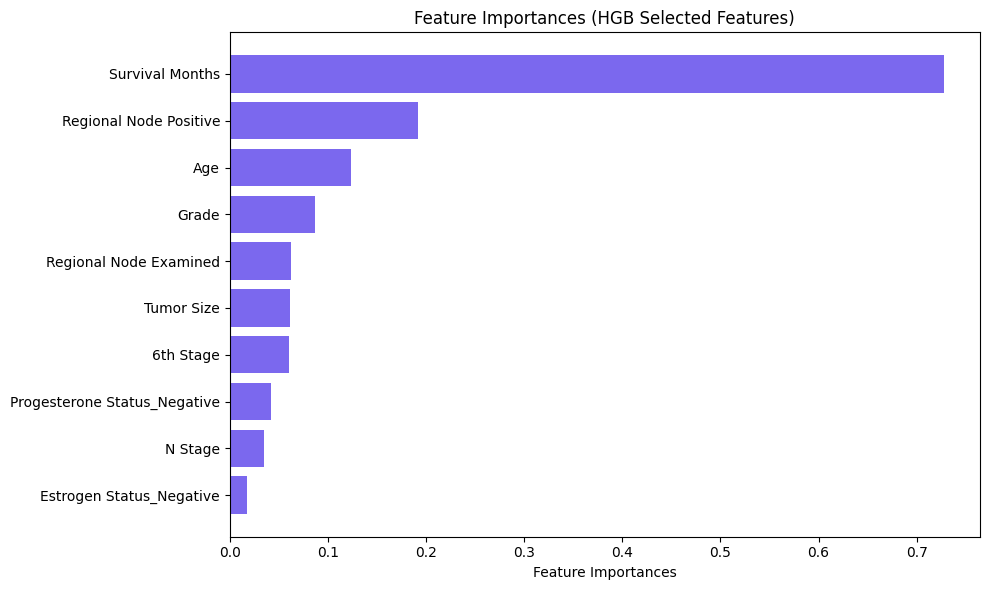

In [199]:
# Map feature names to their SHAP importance scores
feature_dict = dict(zip(X_train.columns, mean_abs_shap))

# Filter to only hgb_selected_features
filtered_feature = {feat: feature_dict[feat] for feat in hgb_selected_features}

# Sort features
sort_shap = sorted(filtered_feature.items(), key = lambda x: x[1], reverse = True)[:10]
features, scores = zip(*sort_shap)

# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (HGB Selected Features)")
plt.barh(range(10), scores[::-1], color = "mediumslateblue", align = "center")
plt.yticks(range(10), features[::-1])
plt.xlabel("Feature Importances")
plt.tight_layout()
plt.show()

* Survival Months, Age, Regional Node Positive, and Grade are the top 4 critical factors for our final model.

### Confusion Matrix

In [200]:
# Function to plot confusion matrix for the best final model
def plot_confusion_matrix_with_percentages(model, predictors, target, threshold):
    """
    Plot confusion matrix with counts and percentages.

    Parameters:
    - model: ML model
    - predictors: predictors
    - target: target variables
    - threshold: optimum threshold for best model performance

    Outcome:
    - Confusion Matrix display
    """
    y_prob = model.predict_proba(predictors)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    # Call the sklearn version, not this function again
    cm = confusion_matrix(target, y_pred)
    total = cm.sum()

    labels = np.array([
        [f"{cm[i, j]}\n{cm[i, j]/total:.2%}" for j in range(2)]
        for i in range(2)
    ])

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot = labels, fmt = "", cbar = False)
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

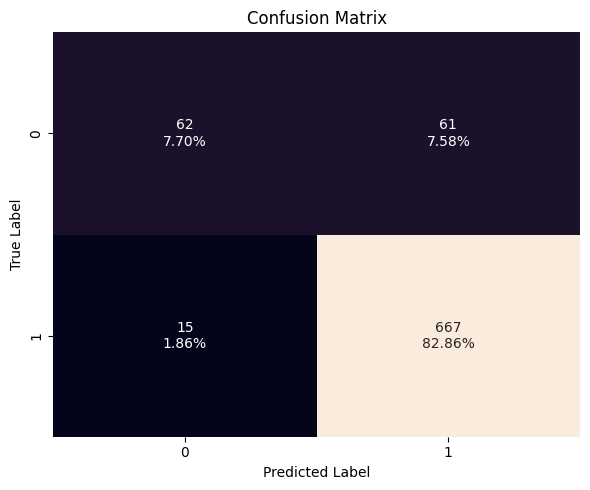

In [201]:
# Plot Confusion Matrix for the best model
plot_confusion_matrix_with_percentages(hgb_tuned, X_test, y_test, threshold = 0.48)

### Precision-Recall AUC

Precision-Recall AUC: 0.9697


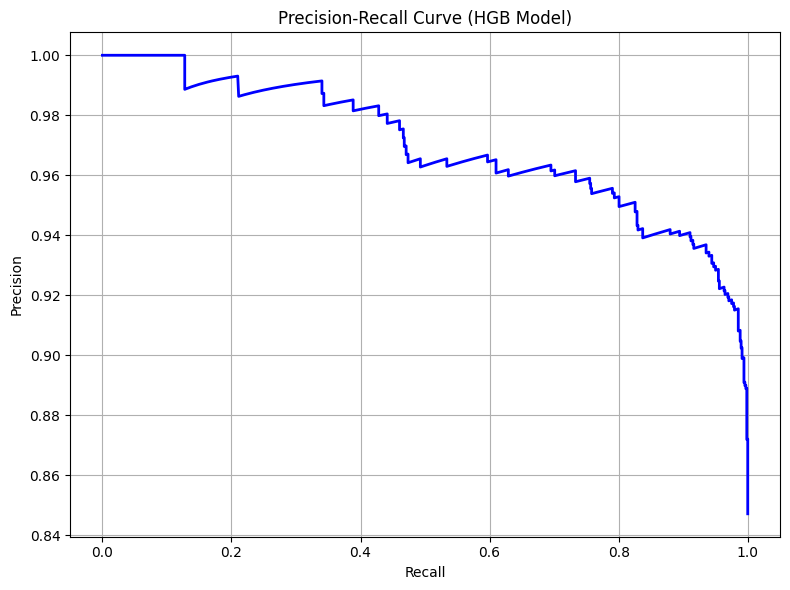

In [203]:
# Calculate Precision-Recall AUC for the final model
y_prob_hgb = hgb_tuned.predict_proba(X_test)[:, 1]
pr_auc = average_precision_score(y_test, y_prob_hgb)

print(f"Precision-Recall AUC: {pr_auc:.4f}")

# Generate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_hgb)

# Plot PR Curve
plt.figure(figsize = (8, 6))
plt.plot(recall, precision, color = 'blue', lw = 2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (HistGradientBoosting)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Final Model Evaluation Report:

### **Confusion Matrix Summary**

* **True Positives (TP)**: 667 / 805 → **82.86%**
* **True Negatives (TN)**: 62 / 805 → **7.70%**
* **False Positives (FP)**: 61 / 805 → **7.58%**
* **False Negatives (FN)**: 15 / 805 → **1.86%**

---

### **Model Performance Summary**

* **Threshold Used**: 0.48
* **Accuracy**: 90.7%
* **Precision**: 91.6%
* **Recall**: 97.9%
* **F1 Score**: 94.7%
* **Precision-Recall AUC (across all thresholds)**: 96.97%

---

### **Interpretation**

* The model correctly classified 90.7% (62 + 667) of all test cases.
* It shows high recall, detecting the majority of alive patients (97.9%).
* False negatives are minimal with only 15 cases.
* The model made 61 false alarms, predicting some deceased patients as alive.
* The Precision-Recall AUC of 96.97% confirms strong overall capability of the model in distinguishing the positive class (alive) across all thresholds.

---

### **Clinical Implications**

* High Recall (82.86%) rate makes the model effective in identifying patients likely to survive.
* The low false negative rate (1.86%) suggests strong potential for real-world deployment in healthcare settings where early detection and preventive intervention are crucial.
* The model’s PR AUC near 97% indicates its reliability even before threshold selection.

---

### **Final Recommendation**

The HistGradient Boosting model with tuned hyperparameters and an optimized threshold of 0.48 demonstrates robust classification performance with more than 90 percent overall. Based on its balanced tradeoff, high recall, and low false negatives, it is well-suited as a final predictive model for breast cancer survival classification in this study. Its Precision-Recall AUC of 96.97% further reinforces its strength as a consistent and trustworthy model across varying thresholds.